# A bilinear DCM for HGA in MEG signals

In [1]:
%pylab inline
import jax, jax.random as jr, jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

import vbjax as vb
import tqdm

import numpyro, time
numpyro.set_host_device_count(jax.local_device_count())
import numpyro.infer, numpyro.distributions as dist
from numpyro.infer import Predictive

import frites
from frites.conn import (conn_covgc, conn_reshape_directed, conn_reshape_undirected)

import seaborn as sns

import random
import sys

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
c[vbjax] ███▒▒▒▒▒▒▒ loading
c[vbjax] (ﾉ☉ヮ⚆)ﾉ ⌒*:･ﾟ✧ can haz 32 cores
c[vbjax] ò_ô shtns is not available
c[vbjax] ᕕ(ᐛ)ᕗ ready


## Read the experimental data to be modelled

In [2]:
base_dir = '../..'
data_path = base_dir+'/data/meg_visuomotor'

### MarsAtlas

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
atlas_path = data_path + '/sc/MarsAtlas_BV_2015.xls'
atlas = pd.read_excel(atlas_path)
 # Cortical ROIs
name_ROIs = atlas['Hemisphere'][0:82] + '_' + atlas['Name'][0:82]
atlas

,Label,Hemisphere,Lobe,Name_FS,Name,Full name,BA,xcoord_2D,ycoord_2D,xcoord_3D,ycoord_3D,zcoord_3D
0,1,L,Occipital,Medial Occipital,VCcm,Caudal Medial Visual Cortex,17/18,-13,11,-47,20,55
1,2,L,Occipital,Lateral Occipital,VCl,Lateral Visual Cortex,37/19/18,-23,16,-34,42,57
2,3,L,Occipital,Superior Occipital,VCs,Superior Visual Cortex,19/39,-16,19,-37,33,83
3,4,L,Occipital,Cuneus,Cu,Cuneus,18/19,-10,24,-44,11,78
4,5,L,Occipital,Lingual,VCrm,Rostral Medial Visual Cortex,18/19,-8,17,-27,15,57
...,...,...,...,...,...,...,...,...,...,...,...,...
92,252,R,Subcortical,Pallidum,GP,Pallidum,0,5,43,25,-19,48
93,253,R,Subcortical,Hippocampus,Hipp,Hippocampus,0,3,31,4,-23,41
94,254,R,Subcortical,Amygdala,Amyg,Amygdala,0,7,36,20,-22,32
95,258,R,Subcortical,Nucleus Accumbens,NAc,Accumbens,0,3,48,39,-9,41


In [4]:
# Choose a random subject
# subject = random.sample(range(1,9),1)
subject = [1]

### Action- or Stimulus-aligned ROIs signals

In [5]:
from abi_dcm.utils.reads import *
meg_data_path = data_path+'/hga/meg_data_stimulus.mat'
time_pts, subject_data = read_subject_data(data_path=meg_data_path, subject=subject, onset_time=False)
subject_data.shape

(105, 82, 400)

In [6]:
ninputs=2  # Initial number of inputs of same kind, but more extra inputs can be added later
ROIs_set = jnp.asarray([22, 15, 0, 63, 56, 41])
# ROIs_set = [0, 15, 22]
ntrl, nvar, ntime = 1, len(ROIs_set), subject_data.shape[2]

In [7]:
xs_mean = jnp.matrix_transpose(jnp.mean(subject_data[:,ROIs_set], axis=0))
xs_exp = jnp.expand_dims(xs_mean, axis=0)
xs_exp.shape

(1, 400, 6)

Text(0.5, 1.0, 'Subject 1 \n Experimental data: MEG envelope Z-scores')

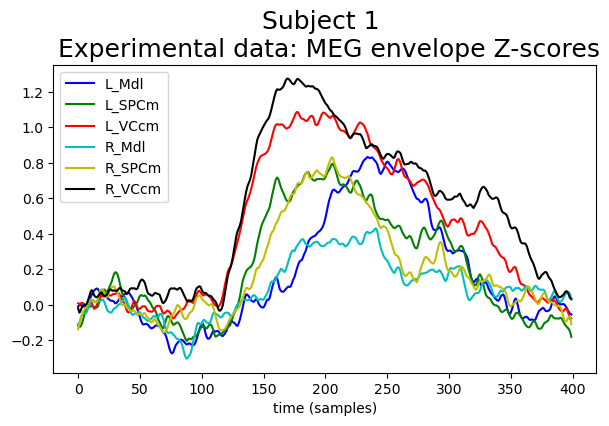

In [8]:
# "nvar" non-reapeating random ROIs
# ROIs_set = random.sample(range(0,82), nvar)
name_ROIs_set = name_ROIs[ROIs_set]

fig = figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=['b', 'g', 'r', 'c', 'y', 'k'])
ax.plot(xs_exp[0], label = name_ROIs_set); legend()
xlabel('time (samples)')
title(f'Subject {subject[0]} \n Experimental data: MEG envelope Z-scores', fontsize=18)

In [9]:
%%script false --no-raise-error
# To save the data back to disk
data=dict()
for i, name in enumerate(name_ROIs_set):
    data[name]=xs_exp[0].T[i]
    
file = open('../../sample_data.json', 'wb')
jax.numpy.save(file,data, allow_pickle=True)
sample_data = numpy.load('../../sample_data.json', allow_pickle=True)
sample_data.item().keys()

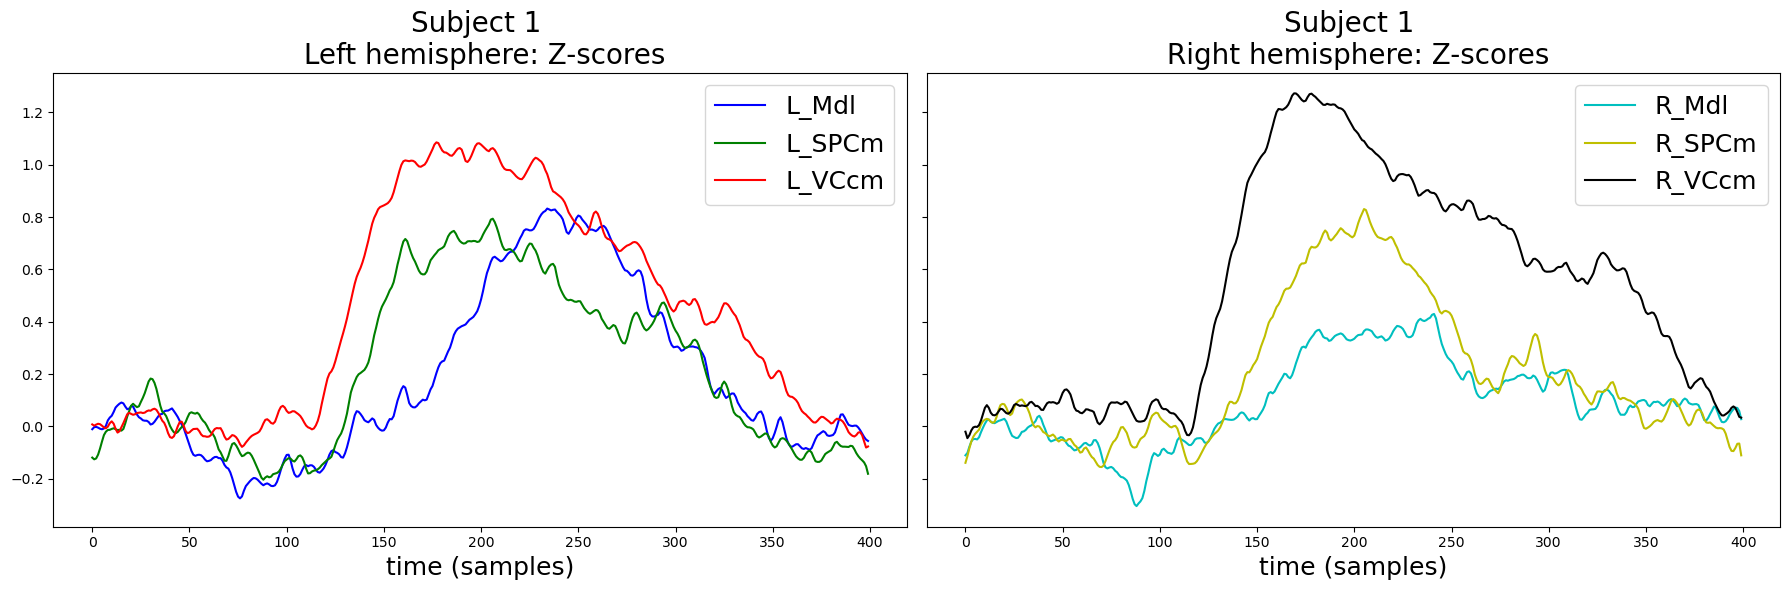

In [10]:
fig, axes = subplots(1, 2, sharey=True, sharex=True)
fig.set_figheight(6); fig.set_figwidth(18)

subplot(121)
axes[0].set_prop_cycle(color=['b', 'g', 'r'])
axes[0].plot(xs_exp[0,...,:3], label = name_ROIs_set[:3]); legend(fontsize=18)
xlabel('time (samples)', fontsize=18)
title(f'Subject {subject[0]} \n Left hemisphere: Z-scores', fontsize=20)

subplot(122)
axes[1].set_prop_cycle(color=['c', 'y', 'k'])
axes[1].plot(xs_exp[0,...,3:], label = name_ROIs_set[3:]); legend(fontsize=18)
xlabel('time (samples)', fontsize=18)
title(f'Subject {subject[0]} \n Right hemisphere: Z-scores', fontsize=20)

tight_layout()

### Observation noise

#### Estimate the observation noise from baseline activity in subject trials

In [11]:
## Concatenates all baseline activity in trials for each single ROI
onset_ind = numpy.where(time_pts==0.)[0][0]
subject_obsnoise_ROIs = jax.vmap(lambda roi: jnp.array(subject_data)[:,roi,:onset_ind].ravel())(ROIs_set).T
subject_obsnoise_ROIs.shape

(12600, 6)

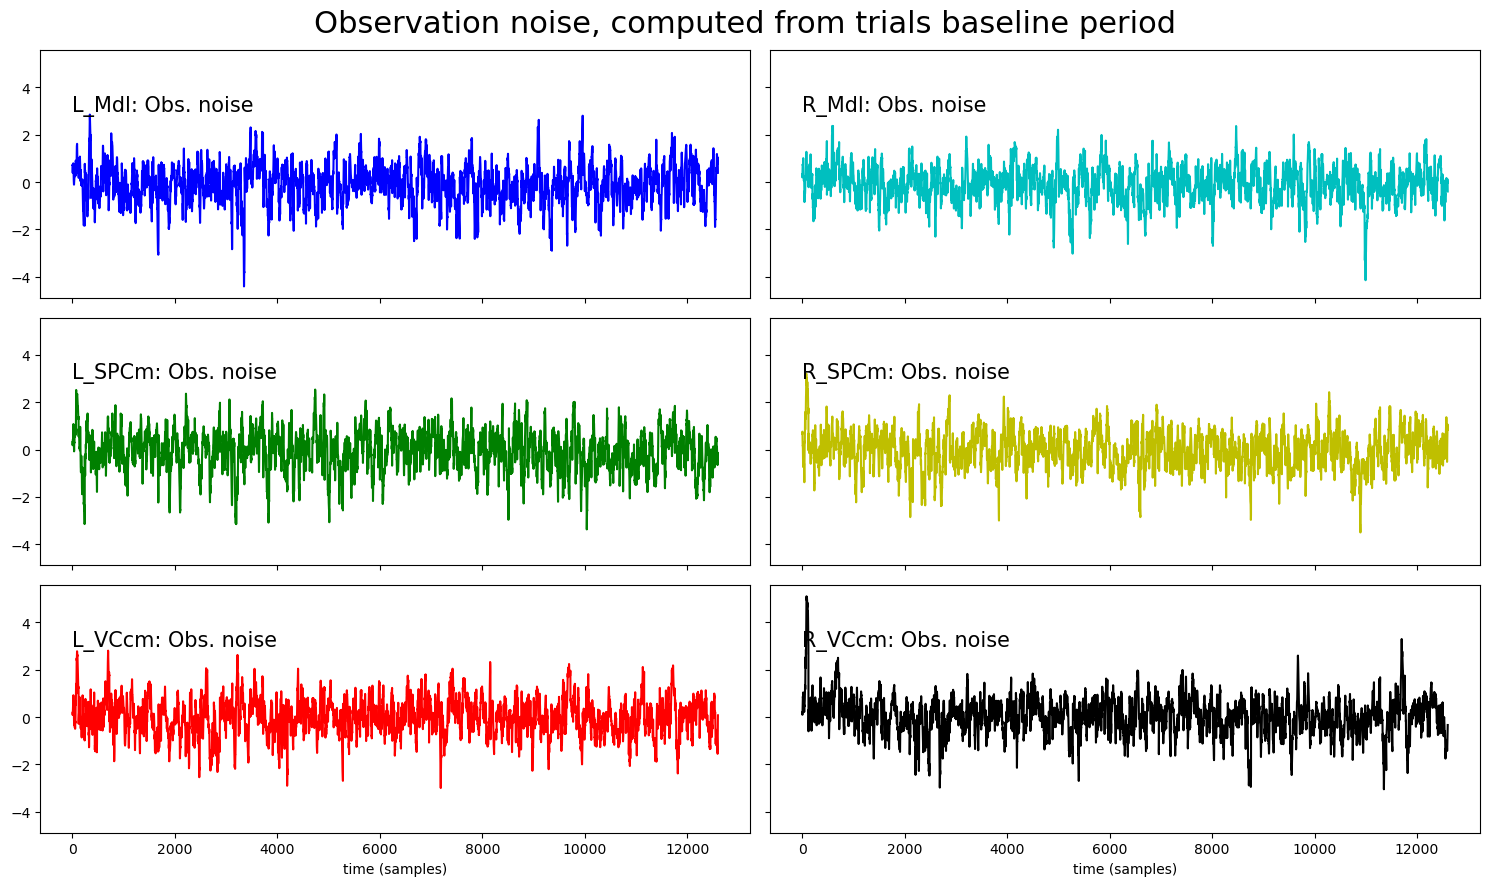

In [12]:
ROIs = range(0,nvar)
color=['b', 'g', 'r', 'c', 'y', 'k']

nrows, ncols = int(nvar/2),2
fig, axes = subplots(nrows, ncols, sharey=True, sharex=True)
fig.set_figheight(3*nrows); fig.set_figwidth(15)

ntrls = subject_data.shape[0]
time_dts_ = jnp.r_[:ntrls*onset_ind]
for row in ROIs[:nrows]:
    # Plot prediction (left hemisphere)
    axes[row, 0].plot(time_dts_, subject_obsnoise_ROIs[:,row], color[row])
    axes[row, 0].text(.1,3., name_ROIs_set.iat[row]+': Obs. noise' , fontsize=15)
    
    # Plot prediction (right hemisphere)
    axes[row, 1].plot(time_dts_, subject_obsnoise_ROIs[:,row+3], color[row+3])
    axes[row, 1].text(.1,3., name_ROIs_set.iat[row+3]+': Obs. noise' , fontsize=15)
    if row==nrows-1:
        axes[row,0].set_xlabel('time (samples)')            
        axes[row,1].set_xlabel('time (samples)')

suptitle('Observation noise, computed from trials baseline period', fontsize=22)        
tight_layout()

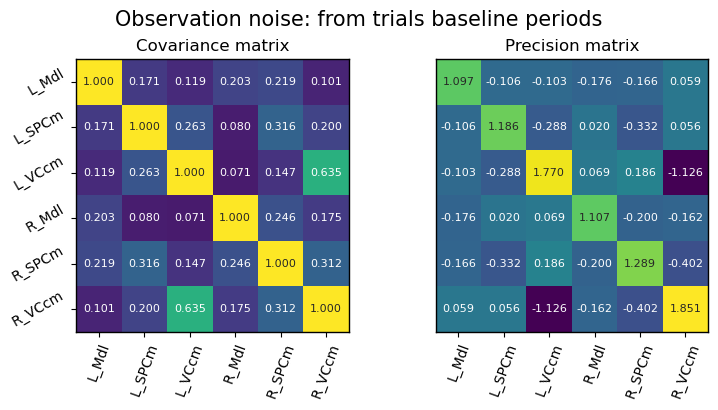

In [13]:
from abi_dcm.utils.plots import *

figure(figsize=(8,4))
shrink, title_size = 1., 12

obs_noise = subject_obsnoise_ROIs
# Baseline observation noise
cov_matrix = jnp.corrcoef(obs_noise.T)
pre_matrix = jnp.linalg.inv(cov_matrix)
subplot(121); plot_matrix(A=cov_matrix, title_str=f'Covariance matrix', title_size=title_size, \
                          shrink=shrink, vmin=0., ytickls=name_ROIs_set, xtickls=name_ROIs_set, no_diag=False, no_zeros=False)
subplot(122); plot_matrix(A=pre_matrix, title_str=f'Precision matrix', title_size=title_size, \
                          shrink=shrink, xtickls=name_ROIs_set, no_diag=False, no_zeros=False)
suptitle('Observation noise: from trials baseline periods', fontsize=15)
tight_layout()

### Covariance-based Granger causality, as defined in Brovelli et al. (2015)

In [14]:
# Exclude baseline activity
xs_exp = jnp.expand_dims(xs_mean[onset_ind:], axis=0)
times= np.squeeze(time_pts[onset_ind:])

In [15]:
xs_exp_asarray = np.asarray(jnp.matrix_transpose(xs_exp))
gc_ = conn_covgc(data=xs_exp_asarray, t0=70, dt=210, step=5, lag=5, n_jobs=-1, times=times, roi = name_ROIs_set, method='gc')

Defining links (n_roi=6; directed=False; net=False, nb_min_links=None)
Compute the  covgc (method=gc, normalised=False, n_pairs=15; n_windows=1, lag=5, dt=210, step=5)


  0%|          |  : 0/15 [00:00<?,       ?it/s]

/home/INT/garcia.p/anaconda3/envs/abi-DCM/lib/python3.11/site-packages/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


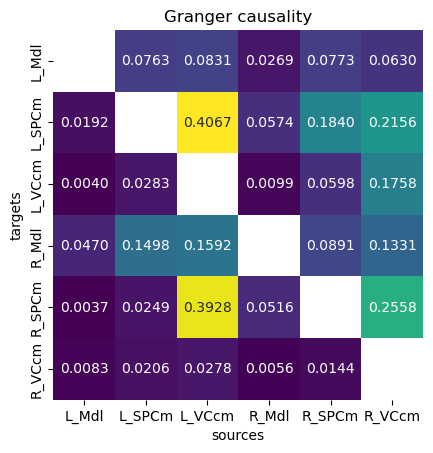

In [16]:
GC=True
# select directed connectivity at 0. and 0.4 seconds
gc_0 = gc_.copy().sel(times=0.6, method='nearest')
gc_0_2d = conn_reshape_directed(gc_0, to_dataframe=True).T

# plot the 2d connectivity arrays
kw = dict(cmap='viridis', square=True, annot=True, fmt=".4f", cbar=False)
# figure(figsize=(5,5))
sns.heatmap(gc_0_2d, **kw)
title('Granger causality')
show()

## Code the DCM in Jax

ntrl  = Number of trials in one subject

nvar  = Number of (cortical) brain signals recorded, e.g. sEEG channels 

ntime = Number of time points, with dt = 5ms (sampling period)

In [17]:
rnd_num = 100
keys = jr.split(jr.PRNGKey(42), rnd_num)

### (1) Create coefficient matrices A, B, C

In [18]:
from abi_dcm.utils.matrices import *

In [19]:
# Matrix 'A' for DCM must contain source coefficients as rows, differently as in 'frites'.
# This, because in vbjax DCM model's implementation, a column vector for sources is used instead of a row vector: A @ x
# Source code: https://github.com/ins-amu/vbjax/blob/main/vbjax/neural_mass.py#L139C1-L139C57

In [20]:
gc = jnp.asarray(conn_reshape_directed(gc_0, to_dataframe=False).T).squeeze()
i_rnd = random.sample(range(0,rnd_num),1)[0]
A_rnd = jr.normal(keys[i_rnd], shape = gc.shape)

diag_idx = jnp.diag_indices_from(gc)
if GC: # A according to Granger causality 

    ### A is based on GC: A ~ GC
    ## Deterministic version
    A_gc = damped_dynamics(gc)
    # Randomized version: A ~ Normal(0,gc)
    gc_rnd = gc * A_rnd
    A_gc_rnd = damped_dynamics(gc_rnd)

    ### A is based on thresholded versions of GC: A ~ threshold(GC)
    thrsh = 0.04
    gc_vals = gc[jnp.where(~jnp.isnan(gc))]
    thr_bool = (gc<thrsh*gc_vals.max())
    gc_thr = gc.at[jnp.where(thr_bool)].set(0)
    ## Non-binary deterministic version
    A_gc_thr = damped_dynamics(gc_thr)

    ## Non-binary randomized version: A ~ Normal(0,gc_thr)
    gc_thr_rnd = gc_thr * A_rnd
    A_gc_thr_rnd = damped_dynamics(gc_thr_rnd)

    ## Binary deterministic version
    gc_thr_bin = gc_thr.at[jnp.where(gc_thr>0)].set(1)
    A_gc_thr_bin = damped_dynamics(gc_thr_bin)

    # Binary randomized version: A ~ Normal(0,gc_thr_bin)
    gc_thr_bin_rnd = gc_thr_bin * A_rnd
    A_gc_thr_bin_rnd = damped_dynamics(gc_thr_bin_rnd)
    
else:  # A by random initialization
    A_damp = damped_dynamics(A_rnd) # damped dynamics at each node

/home/INT/garcia.p/anaconda3/envs/abi-DCM/lib/python3.11/site-packages/frites/conn/conn_utils.py:520: FutureWarning: the `pandas.MultiIndex` object(s) passed as 'roi' coordinate(s) or data variable(s) will no longer be implicitly promoted and wrapped into multiple indexed coordinates in the future (i.e., one coordinate for each multi-index level + one dimension coordinate). If you want to keep this behavior, you need to first wrap it explicitly using `mindex_coords = xarray.Coordinates.from_pandas_multiindex(mindex_obj, 'dim')` and pass it as coordinates, e.g., `xarray.Dataset(coords=mindex_coords)`, `dataset.assign_coords(mindex_coords)` or `dataarray.assign_coords(mindex_coords)`.
  da[axis] = pd.MultiIndex.from_arrays(


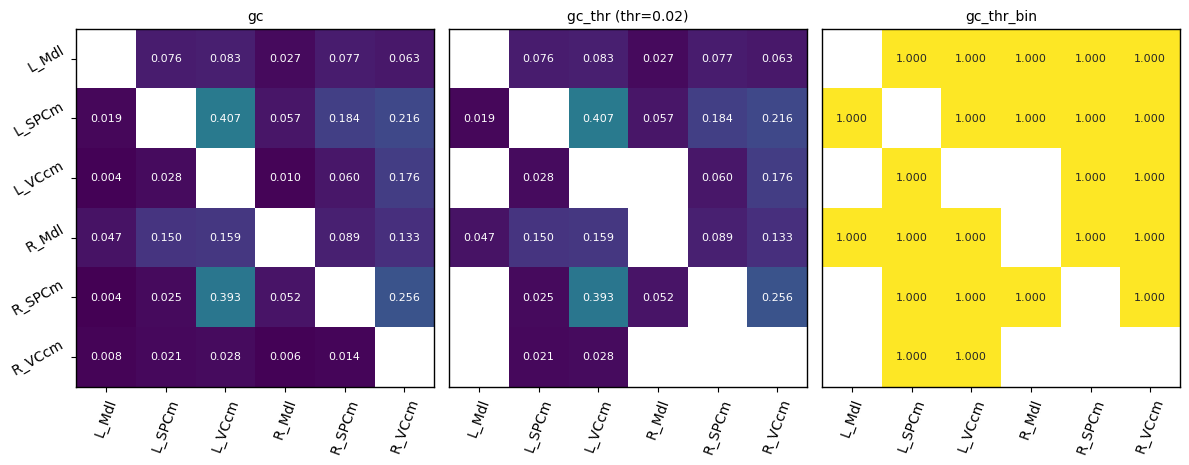

In [21]:
title_size=10

thr_num=f'(thr={thrsh*gc_vals.max():.2f})'

if GC:
    figure(figsize=(12,9))
    subplot(131); plot_matrix(A=gc, title_str='gc', title_size=title_size, ytickls=name_ROIs_set, vmin=0, vmax=1., xtickls=name_ROIs_set)
    subplot(132); plot_matrix(A=gc_thr, title_str=f'gc_thr {thr_num}', title_size=title_size, vmin=0, vmax=1., xtickls=name_ROIs_set)
    subplot(133); plot_matrix(A=gc_thr_bin, title_str='gc_thr_bin', title_size=title_size, vmin=0, vmax=1., xtickls=name_ROIs_set)

else:
    subplot(121); sns.heatmap(A=A_rnd, **kw, cbar_kws={"shrink": .35}); title('gc')
    subplot(122); sns.heatmap(A=A_damp, **kw, cbar_kws={"shrink": .35})
    title('A_rnd', fontsize=25)

tight_layout()

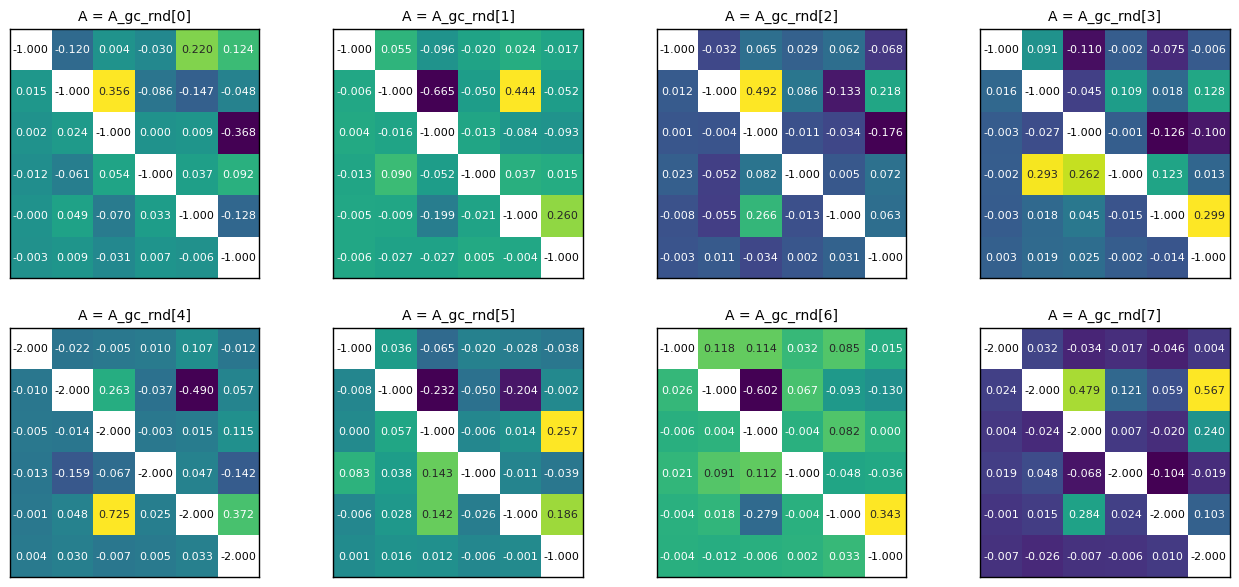

In [22]:
thr_str = ''
rnd_str = '_rnd'
A_str = 'gc'+thr_str+rnd_str
exec(f'gc_ref = gc{thr_str}')
    
A_init = jnp.zeros((rnd_num,nvar,nvar,))
for i_rnd in arange(rnd_num):
    A_rnd = jr.normal(keys[i_rnd], shape = gc.shape)
    
    if GC: # A according to Granger causality 
        # Randomized version: A ~ Normal(0,gc_ref)
        gc_ref_rnd = gc_ref * A_rnd
        A_gc_ref_rnd = damped_dynamics(gc_ref_rnd)
        A_init = A_init.at[i_rnd].set(A_gc_ref_rnd)

figure(figsize=(16,11))
for i_rnd in arange(8):
    subplot(3,4,i_rnd+1); plot_matrix(A_init[i_rnd], title_str=f'A = A_{A_str}[{i_rnd}]', title_size=title_size)

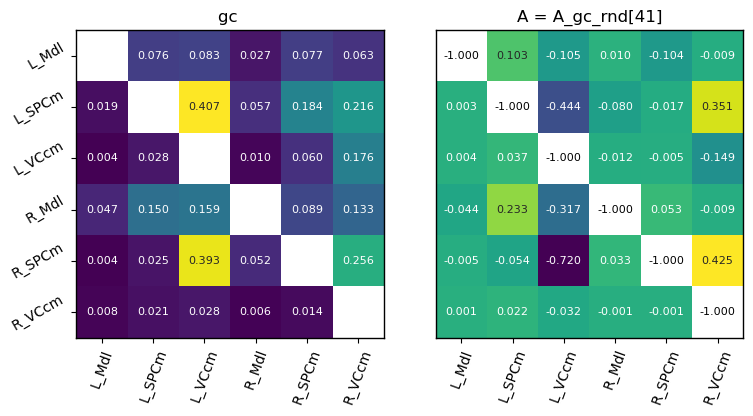

In [23]:
i_rnd = random.sample(range(0,rnd_num),1)[0]
exec(f'A = A_init[{i_rnd}]')
A_diag = A[0,0]

figure(figsize=(8,4))
if 'thr' in thr_str:
    thr_num_=thr_num
else:
    thr_num_=''

shrink, title_size = .62, 12
subplot(121); plot_matrix(A=gc_ref, title_str=f'gc{thr_str} {thr_num_}', shrink=shrink, title_size=title_size,\
                          xtickls=name_ROIs_set, ytickls=name_ROIs_set)
subplot(122); plot_matrix(A=A, title_str=f'A = A_{A_str}[{i_rnd}]', shrink=shrink, title_size=title_size, xtickls=name_ROIs_set)

tight_layout()

In [24]:
B = jnp.zeros((nvar, nvar, ninputs))
# u3 modulates connection from node 1 to node 2
# B = B.at[1,0,2].set(1)
B.shape

(6, 6, 2)

In [25]:
stim_shape='Gamma'

L_VCcm_max, R_VCcm_max = xs_exp[0,...,2].max(), xs_exp[0,...,5].max()
stim_h_max = 90*abs(A_diag)*jnp.asarray([L_VCcm_max, R_VCcm_max])
stim_h = stim_h_max*jr.lognormal(keys[3], 1/16, shape=(ninputs,))

# Nodes receiving direct exogenous inputs
roi_stim = jnp.asarray([2,5])
C = jnp.zeros((nvar, ninputs))
C = C.at[roi_stim[0],0].set(stim_h[0]) # u1 drives node 3
C = C.at[roi_stim[1],1].set(stim_h[1]) # u2 drives node 6
C.shape

(6, 2)

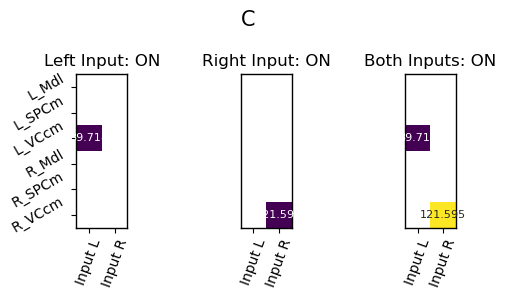

In [26]:
figure(figsize=(6,3))

subplot(131); plot_matrix(A=C*jnp.r_[1,0], title_str='Left Input: ON', title_size=12, ytickls=name_ROIs_set, \
                          xtickls=['Input L', 'Input R'], no_diag=False)
subplot(132); plot_matrix(A=C*jnp.r_[0,1], title_str='Right Input: ON', title_size=12, xtickls=['Input L', 'Input R'], no_diag=False)
subplot(133); plot_matrix(A=C*jnp.r_[1,1], title_str='Both Inputs: ON', title_size=12, shrink=0.95, \
                          xtickls=['Input L', 'Input R'], no_diag=False)
suptitle('C', fontsize=15)
tight_layout()

### (2) Build a stimulus signal

In [27]:
from abi_dcm.utils.stims import *

In [28]:
# Build a stimulus signal
dur, dt = 0.750, time_pts[1]-time_pts[0] # seconds
dur_dt = int(ceil(dur/dt)) # time steps

/tmp/ipykernel_147312/3504205247.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dur_dt = int(ceil(dur/dt)) # time steps


In [29]:
L_VCcm_idx, R_VCcm_idx = xs_exp[0,...,2].argmax(), xs_exp[0,...,5].argmax()
pos_max = jnp.asarray([[L_VCcm_idx],[R_VCcm_idx]])/2.0

if stim_shape=='Gamma':
    stim_sh = 1
    # Parameters for Gamma-shape input functions, as in Chen et al.[2008]
    theta_sigma = 2*pos_max**2*jr.lognormal(keys[5],1/16, shape=(ninputs,1))
    while True: # alpha must be larger than 1
        theta_mu = 2*pos_max*jr.lognormal(keys[4],1/16, shape=(ninputs,1))
        if (theta_mu > jnp.sqrt(theta_sigma)).all:
            break
    
    alpha = theta_mu**2/theta_sigma
    beta = theta_mu/theta_sigma
    stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, ntime=ntime, alpha=alpha, beta=beta)
    
else: # Alpha input
    stim_sh = 0
    stim_tau = pos_max*jr.lognormal(keys[12],1/16, shape=(ninputs,1))
    stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, ntime=ntime, stim_tau=stim_tau)

(0.0, 400.0)

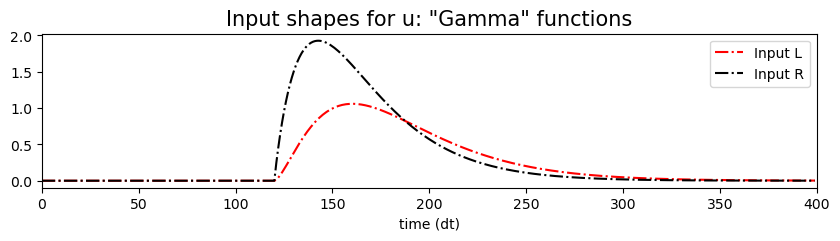

In [30]:
figure(figsize=(10,2))
plot(C[2,0]*stim[0, 0].T, 'r-.', label = 'Input L'); legend()
plot(C[5,1]*stim[0, 1].T, 'k-.', label = 'Input R'); legend()
title(f'Input shapes for u: "{stim_shape}" functions', fontsize=15)
xlabel('time (dt)')
xlim(0,400)

### (4) Convergence time constant, as in Chen et al. (2008)

In [31]:
# In ODEs, dt should be small enough than all time constants, e.g. tau >= ~10*dt
tau = 1/16*jr.lognormal(keys[40],1/4) #in seconds
tau, tau/dt

(Array(0.05711276, dtype=float64), Array([11.42255175], dtype=float64))

### Some model simulations

In [32]:
# Create time series for noise
# n_std = subject_obsnoise_ROIs.std()
n_std = 0.00
eps = n_std*jr.normal(jr.PRNGKey(42), shape=(ntrl, ntime-onset_ind, nvar))
eps.shape

(1, 280, 6)

In [33]:
# Experimental conditions
conditions = (jnp.r_[1,0], # Condition 1: Activates u1
              jnp.r_[0,1], # Condition 2: Activates u2
              jnp.r_[1,1], # Condition 3: Activates all inputs
             )
nconds=len(conditions)

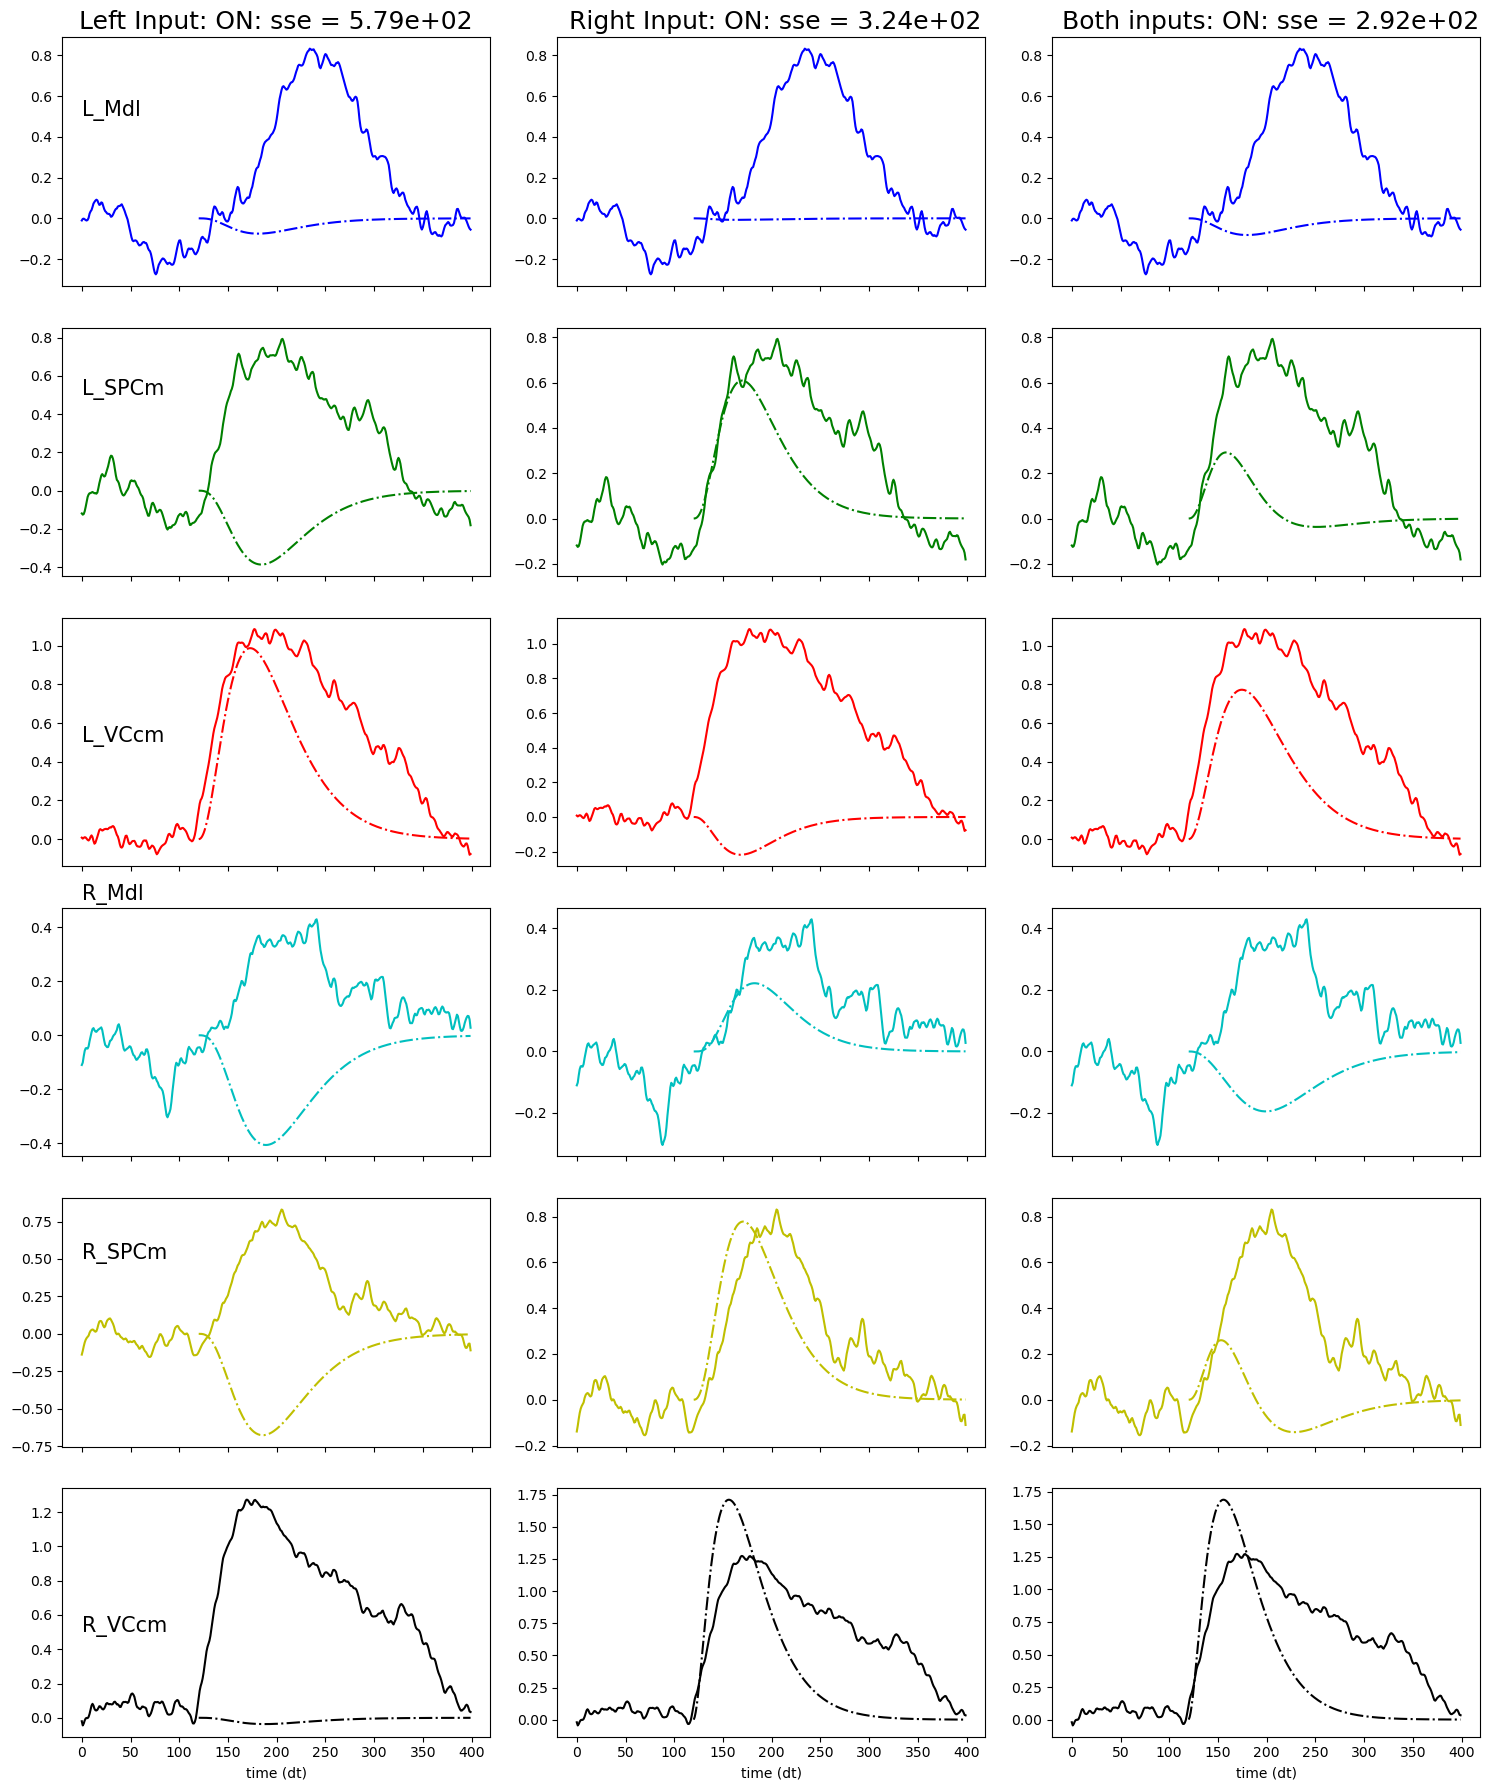

In [34]:
from abi_dcm.utils.models import *

ts = jnp.r_[onset_ind:ntime]
x0 = jnp.zeros(nvar)

titles = 'Left Input: ON, Right Input: ON, Both inputs: ON'.split(',')
nrows, ncols = nvar, len(conditions)

fig, axes = subplots(nrows, ncols, sharey=False, sharex=True)
fig.set_figheight(3*nvar); fig.set_figwidth(15)

sse = lambda x,y: jnp.sum(jnp.square(x-y))
us = jnp.matrix_transpose(stim[...,ts])
time_dts = jnp.r_[:ntime]
TRLs = jnp.r_[:ntrl]
for i, cond in enumerate(conditions):
    C_cond = C*conditions[i]
    p = vb.DCMTheta(A=A/tau, B=B/tau, C=C_cond/tau)
    xs = dcm_bilinear_predict(TRLs, dt, x0, ts, us, p, eps).squeeze()

    for roi in ROIs:
        ax = axes[roi, i]   

        # Plot prediction
        ax.plot(ts, xs[:,roi], linestyle='-.', color=color[roi])
        ax.plot(time_dts, xs_mean[:,roi], color=color[roi])
        if roi==0:
            ax.set_title(f'{titles[i]}: sse = {sse(xs, xs_exp):0.2e}', fontsize=18)
        if roi==nvar-1:
            ax.set_xlabel('time (dt)')
        if i==0:
            ax.text(.1,.5, name_ROIs_set.iat[roi], fontsize=15) 
            
tight_layout()

## Model optimizations

### Gradient descent methods

In [35]:
GD = False

#### Optimizing all Matrices coefficients, and input parameters with possitive bounds, by means of jaxopt.ScipyBoundedMinimize

In [36]:
from abi_dcm.grad_desc.cost_functs import *

In [37]:
# %%script false --no-raise-error
GD = True

In [38]:
cond_idx = [0,1,2]
if GD:
    from jaxopt import ScipyBoundedMinimize
    
    # Flattening and concatenate all the parameters into a unique vector, 
    # as required by jaxopt's syntaxis

    # Form a vector of input parameters
    if stim_shape=='Gamma':
        stim_pars_vec = jnp.concatenate([alpha.flatten(), beta.flatten()])
        stim_pars_shape = (alpha.shape[0]+beta.shape[0],1)
    else:
        stim_pars_vec = stim_tau.flatten()
        stim_pars_shape = stim_tau.shape

    stim_pars_gd_all = jnp.zeros((nconds,rnd_num,)+stim_pars_vec.shape)
    stim_pars_gd = jnp.zeros((nconds,)+stim_pars_shape)
    C_gd_ = jnp.zeros((nconds,)+C.shape)
    A_gd_ = jnp.zeros((nconds,)+A.shape)
    
    A_triu_idx, A_tril_idx = nZero_coeff_idx(A)
    size_triu, size_tril = A_triu_idx[0].size, A_tril_idx[0].size
    Optimizer = ScipyBoundedMinimize(fun=loss_fun_all, maxiter=70000, method="L-BFGS-B", jit=False) #  method="Nelder-Mead")
    for i_cond in cond_idx:
        
        tic = time.time()
        print(f'Fitting model configuration {i_cond+1}...')

        # Form a flat vector on non-null coefficients in C
        C_cond_nZero_idx = jnp.where(C*conditions[i_cond])
        C_stim = C[C_cond_nZero_idx]

        for i_rnd in arange(1):
            # print(f' Initializing matrix A as A = A_{A_str}[{i_rnd}]:')
            A = A_init[i_rnd]
            # Form a vector on non-null coefficients in A
            A_triu_vec, A_tril_vec = A[A_triu_idx], A[A_tril_idx]
            A_diag_arr = jnp.asarray([A[0,0]])
            # print(f'  Intitial A_diag value: {A[0,0]: .3f}')
            
            # Call Optimization algorithm
            n_params = len(stim_pars_vec)
            p_hat_vec = jnp.concatenate([A_triu_vec, A_tril_vec, A_diag_arr, C_stim, stim_pars_vec])
            if stim_shape=='Gamma':
                # alpha must be larger than 1
                lower_bounds = jax.lax.dynamic_update_slice(-jnp.ones_like(p_hat_vec)*jnp.inf, jnp.array([1.95,1.95,.010,.010]), (-n_params,))
                upper_bounds = jax.lax.dynamic_update_slice( jnp.ones_like(p_hat_vec)*jnp.inf, jnp.array([3.00,3.00,.025,.025]), (-n_params,))        
            else:
                lower_bounds = jax.lax.dynamic_update_slice(-jnp.ones_like(p_hat_vec)*jnp.inf, jnp.ones(n_params)*dur_dt/10, (-n_params,))
                upper_bounds = jax.lax.dynamic_update_slice(jnp.ones_like(p_hat_vec)*jnp.inf, jnp.ones(n_params)*dur_dt, (-n_params,))        
            bounds = (lower_bounds, upper_bounds)
            Optimizer_sol = Optimizer.run(p_hat_vec, bounds, A_triu_idx, A_tril_idx, B, C.shape, C_cond_nZero_idx, stim_sh, \
                                          pos_max, tau, TRLs, dt, x0, ntime, onset_ind, eps, xs_exp)

            # Reconstruct matrix A from a flat vector of estimated coefficients
            # Upper triangle of A
            A_triu_vec = jax.lax.dynamic_slice(Optimizer_sol.params, (0,), (size_triu,))
            A_gd_triu_idx = (jnp.tile(i_cond,(size_triu,)),) + A_triu_idx
            A_gd_ = A_gd_.at[A_gd_triu_idx].set(A_triu_vec)
            # Lower triangle of A
            A_tril_vec = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu,), (size_tril,))
            A_gd_tril_idx = (jnp.tile(i_cond,(size_tril,)),) + A_tril_idx
            A_gd_ = A_gd_.at[A_gd_tril_idx].set(A_tril_vec)
            # Diagonal of A
            A_gd_diag = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu+size_tril,), (1,))
            A_gd_diag_idx = (jnp.tile(i_cond,(nvar,)),) + diag_idx
            A_gd_ = A_gd_.at[A_gd_diag_idx].set(A_gd_diag) # Damped dynamics at each node
            # print(f'  Estimated A_diag value: {A_gd_diag[0]: .3f}')
    
            # Reconstruct matrix C from a flat vector of estimated coefficients
            C_opt = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu+size_tril+1,),(len(C_stim),))
            C_gd_nZero_idx = (jnp.tile(i_cond,(len(C_stim),)),) + C_cond_nZero_idx
            C_gd_ = C_gd_.at[C_gd_nZero_idx].set(C_opt)
    
            # Reconstruct input's parameters from a flat vector of estimated values
            stim_pars_opt = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu+size_tril+1+len(C_stim),),(len(stim_pars_vec),))
            stim_pars_gd_all = stim_pars_gd_all.at[i_cond,i_rnd].set(stim_pars_opt)

        stim_pars_resh = jnp.reshape(mean(stim_pars_gd_all[i_cond], axis=0), stim_pars_shape)
        stim_pars_gd = stim_pars_gd.at[i_cond].set(stim_pars_resh)
        
        toc = time.time() - tic
        print(f' Elapsed time: {toc: .2f} secs')

Fitting model configuration 1...
 Elapsed time:  105.30 secs
Fitting model configuration 2...
 Elapsed time:  2.63 secs
Fitting model configuration 3...
 Elapsed time:  105.31 secs


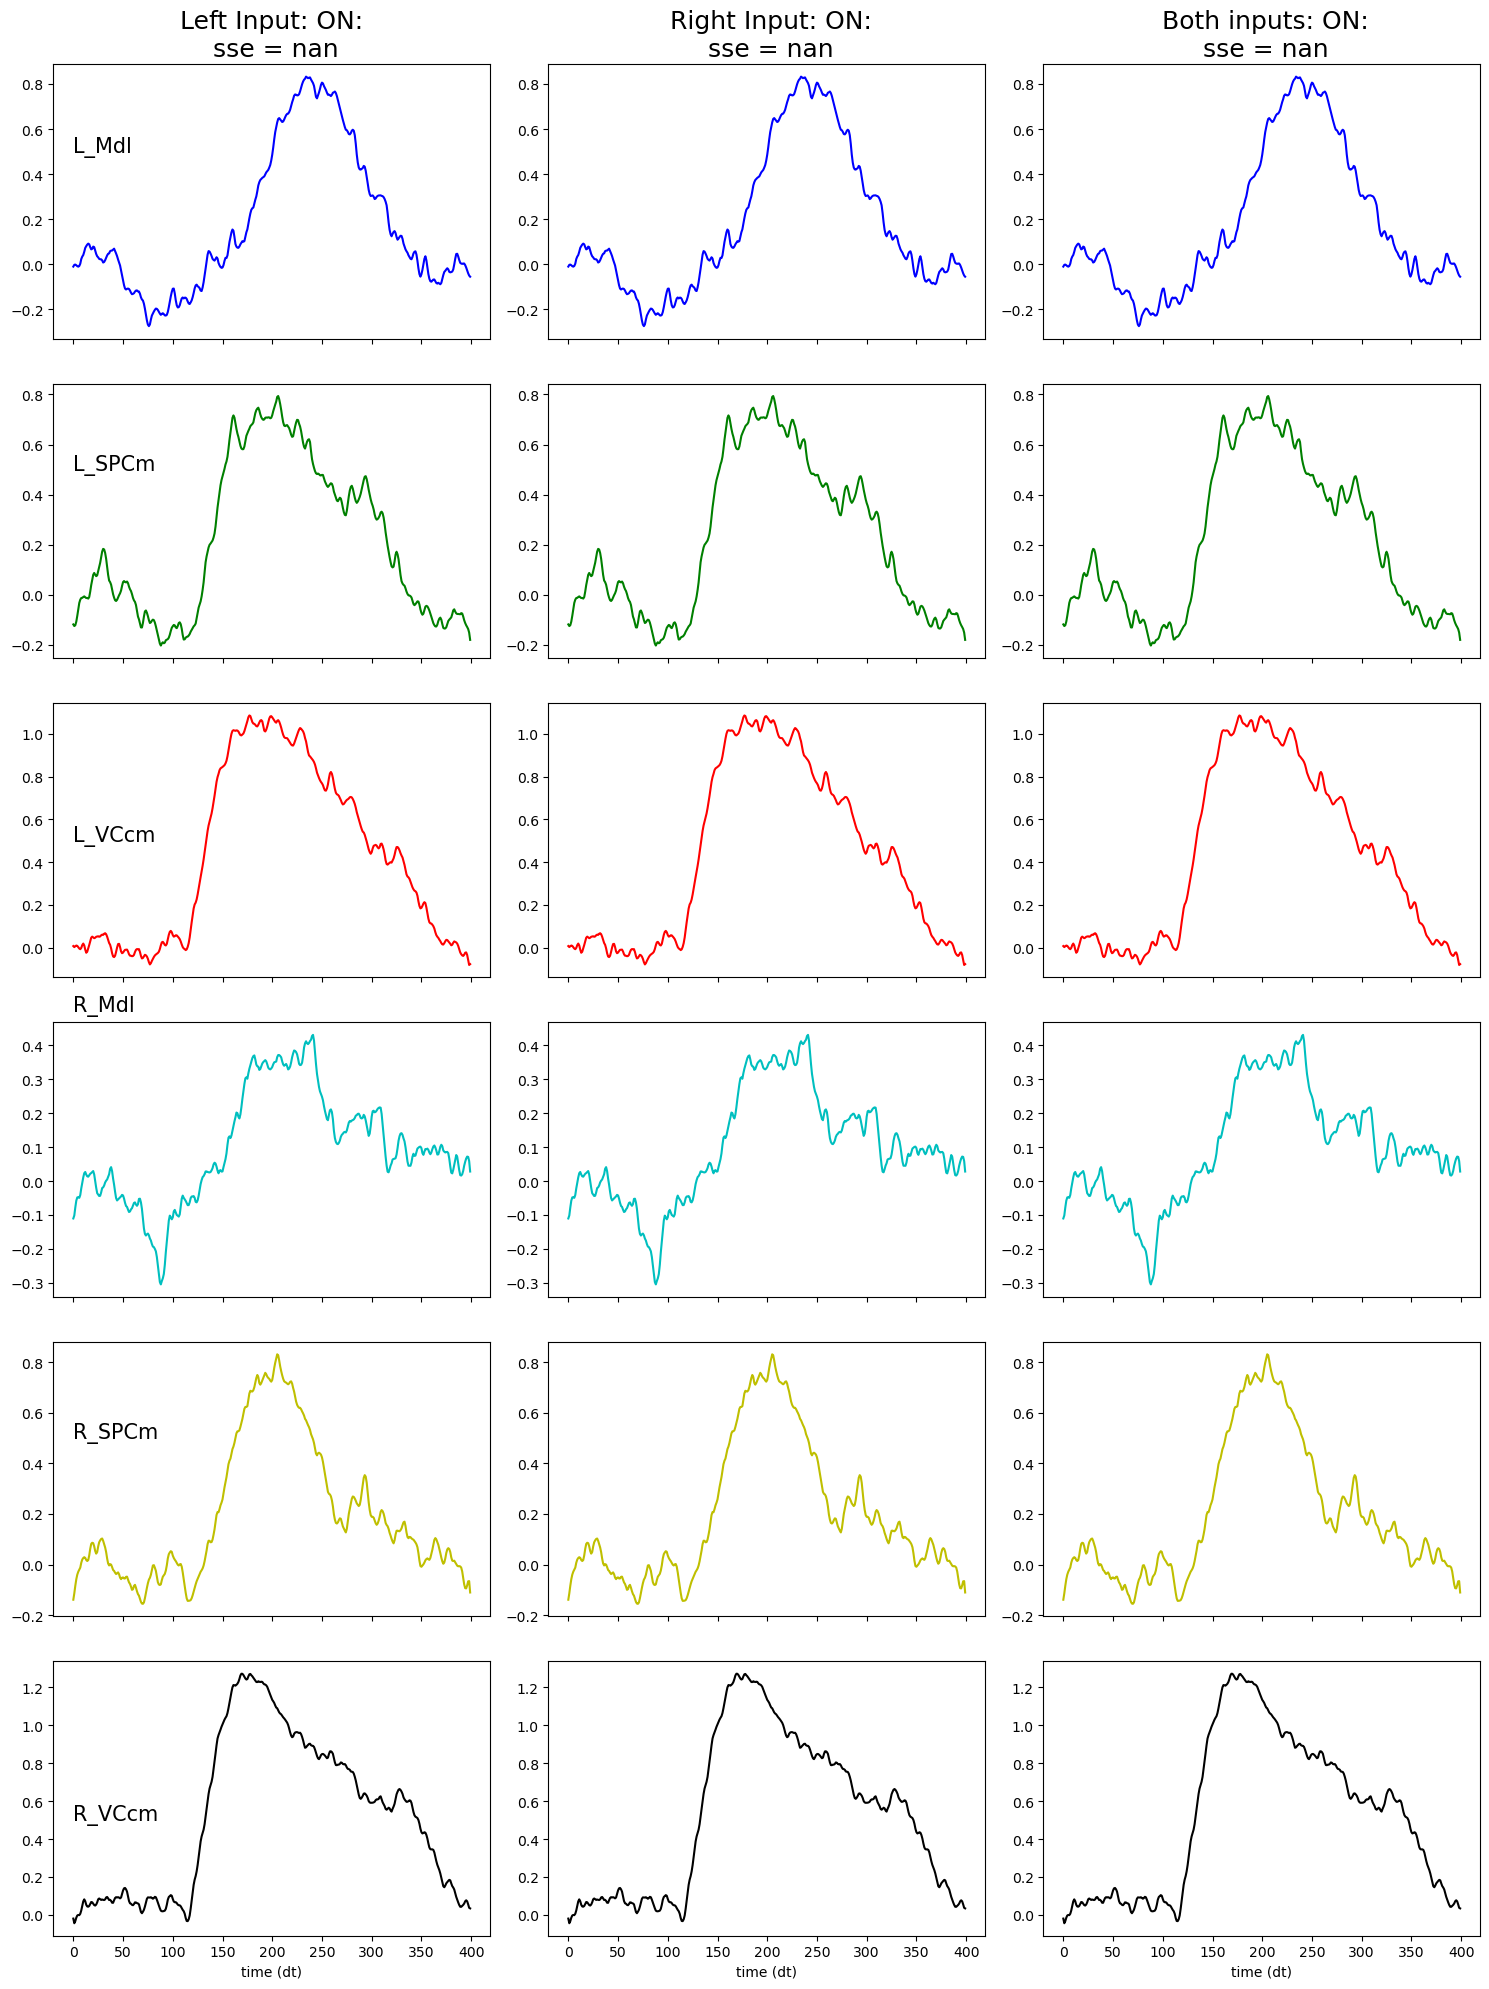

In [39]:
if GD:   
    fig, axes = subplots(nrows, ncols, sharey=False, sharex=True)
    fig.set_figheight(20); fig.set_figwidth(15)

    sse_conds_ = []
    time_dts = jnp.r_[:ntime]
    for i_cond in cond_idx: # range(nconds):

        # Extracting Matrices's coefficients from tensor of estimated values
        A_cond, C_cond = A_gd_[i_cond], C_gd_[i_cond]

        # Extracting Input's parameters from tensor of estimated values
        if stim_shape=='Gamma':
            alpha_cond, beta_cond = stim_pars_gd[i_cond,:ninputs], stim_pars_gd[i_cond,ninputs:]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, ntime=ntime, stim_onset=onset_ind, alpha=alpha_cond, beta=beta_cond)
        else:
            stim_tau_cond = stim_pars_gd[i_cond]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, ntime=ntime, stim_onset=onset_ind, stim_tau=stim_tau_cond)
        us_hat = jnp.matrix_transpose(stim[...,ts])

        # Model prediction
        phat = vb.DCMTheta(A=A_cond/tau, B=B/tau, C=C_cond/tau)
        xs_hat_gd = dcm_bilinear_predict(TRLs, dt, x0, ts, us_hat, phat, eps).squeeze()
        
        sse_cond = sse(xs_hat_gd, xs_exp)
        sse_conds_.append(sse_cond)
        for roi in ROIs:
            ax = axes[roi,i_cond]   
    
            # Plot prediction
            ax.plot(ts, xs_hat_gd[:,roi], color=color[roi], linestyle='-.')
            ax.plot(time_dts, xs_mean[:,roi], color=color[roi])
            if roi==0:
                ax.set_title(f'{titles[i_cond]}:\n sse = {sse_cond:0.2e}', fontsize=18)
            if roi==nvar-1:
                ax.set_xlabel('time (dt)')
            if i_cond==0:
                ax.text(.1,.5, name_ROIs_set.iat[roi], fontsize=15)
                
    tight_layout()

#### Matrix A: relation between experimental data and estimated effective connectivity

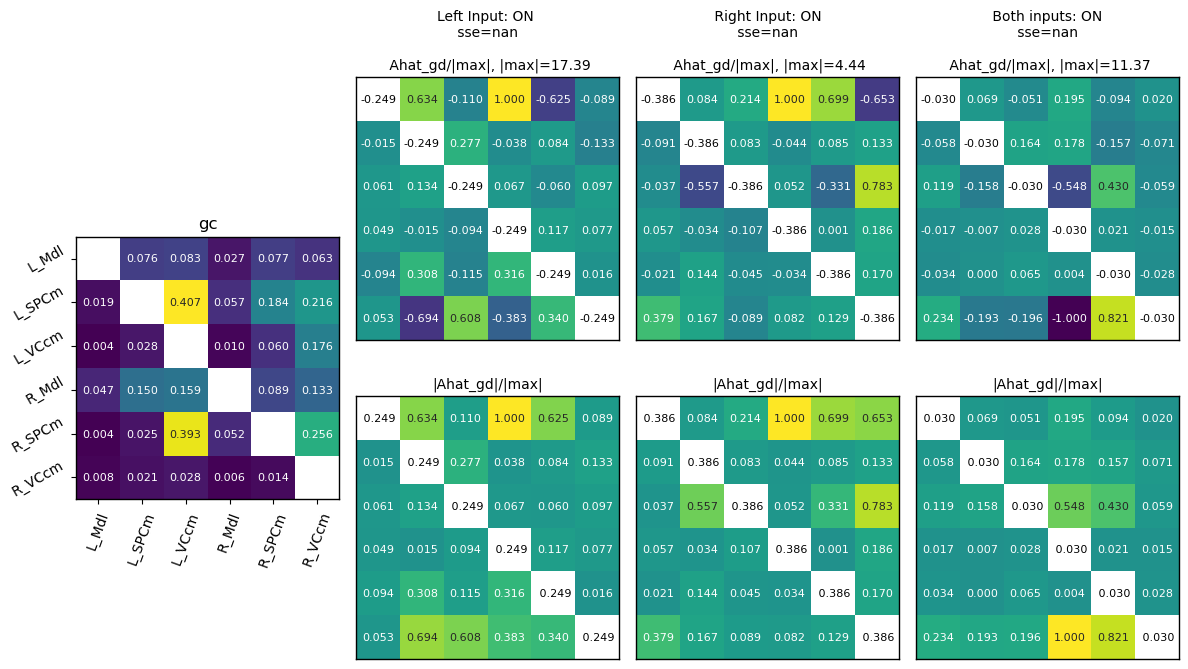

In [40]:
# %%script false --no-raise-error
if GD:

    vmin, vmax = -1, 1
    title_size = 10
    
    fig = figure(figsize=(12,7))
    subplot(1,4,1); plot_matrix(A=gc_ref, shrink = 0.75, title_str=f'gc{thr_str}', title_size=12, ytickls=name_ROIs_set, xtickls=name_ROIs_set)
    
    for i_cond in cond_idx:
        A_gd_max_ = [jnp.abs(A_gd_[i_cond]).max() for i_cond in cond_idx]
        
        subplot(2,4,i_cond + 2); plot_matrix(A=A_gd_[i_cond]/A_gd_max_[i_cond], \
                                             title_str=f'{titles[i_cond]} \n sse={sse_conds_[i_cond]:.2e} \n\n Ahat_gd/|max|, |max|={A_gd_max_[i_cond]:.2f}', \
                                             title_size=title_size, vmin=vmin, vmax=vmax, shrink = 0.75)
        subplot(2,4,i_cond + 6); plot_matrix(A=jnp.abs(A_gd_[i_cond])/A_gd_max_[i_cond], \
                                             title_str='|Ahat_gd|/|max|', \
                                             title_size=title_size, vmin=vmin, vmax=vmax, shrink = 0.75)
        
    tight_layout()

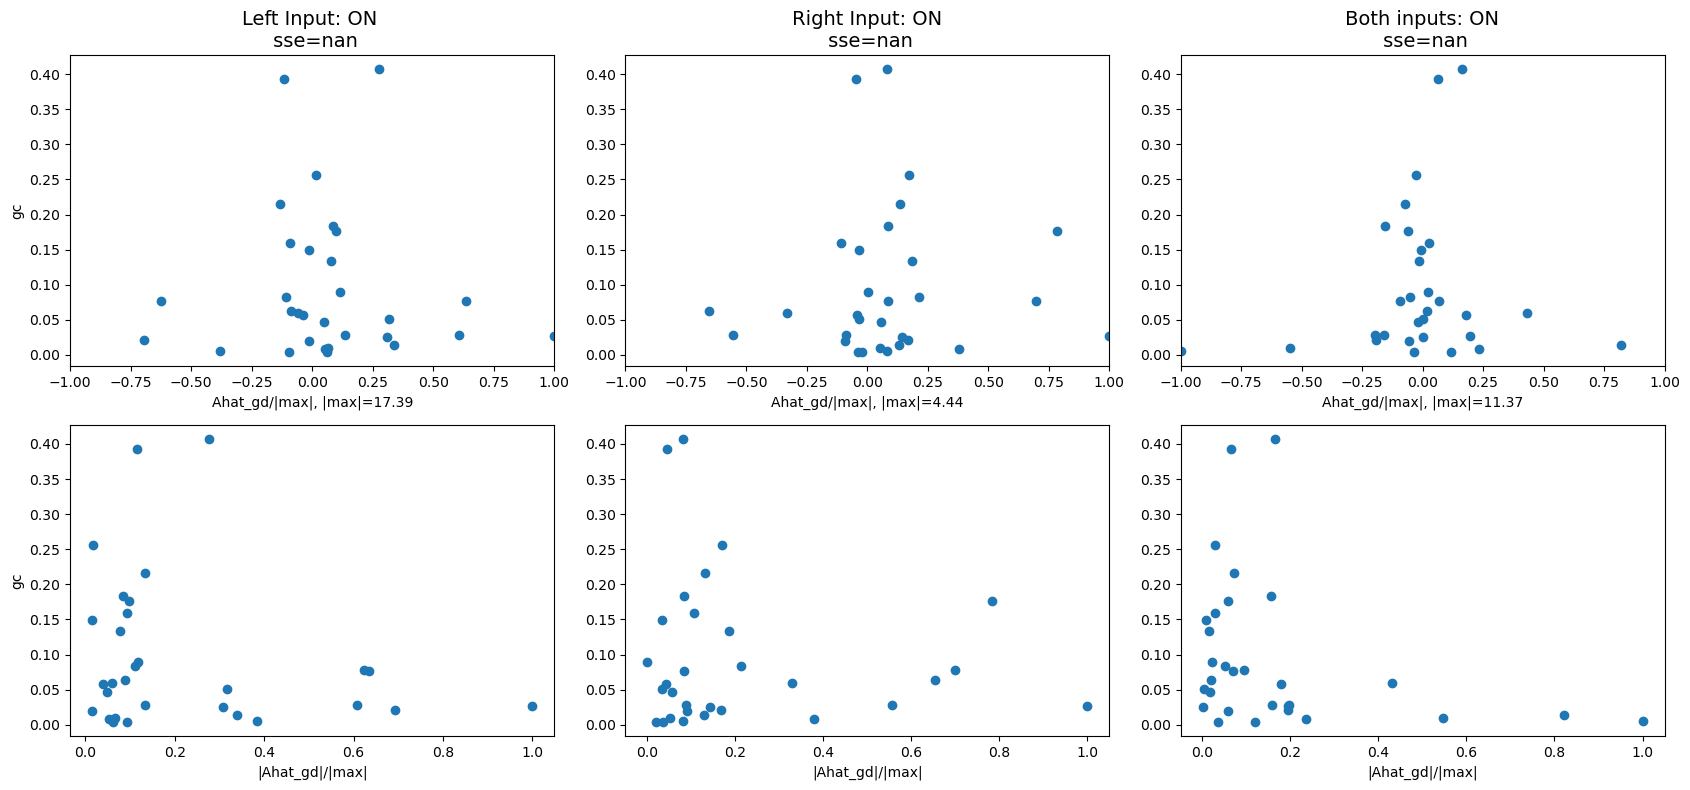

In [41]:
if GD:
    figure(figsize=(17,8))

    for i_cond in cond_idx: # range(nconds):
        # Extracting Matrices's coefficients from tensor of estimated values
        A_cond = A_gd_[i_cond]

        # Plotting A vs experimental GC
        subplot(2,3,i_cond+1)
        y = jnp.concatenate([    gc[A_triu_idx],     gc[A_tril_idx]])
        x = jnp.concatenate([A_cond[A_triu_idx], A_cond[A_tril_idx]])/A_gd_max_[i_cond]
        plot(x,y,'o')
        title(f'{titles[i_cond]} \n sse={sse_conds_[i_cond]:.2e}', fontsize=14)
        xlabel(f'Ahat_gd/|max|, |max|={A_gd_max_[i_cond]:.2f}', fontsize=10)
        xlim(-1,1)
        if i_cond==0:
            ylabel('gc')

       # Plotting |A| vs experimental GC
        # Plotting |A| vs experimental GC
        subplot(2,3,i_cond+4)
        y = jnp.concatenate([   gc[A_triu_idx],    gc[A_tril_idx]])
        x = jnp.concatenate([jnp.abs(A_cond[A_triu_idx]), jnp.abs(A_cond[A_tril_idx])])/A_gd_max_[i_cond]
        plot(x,y,'o')
        xlabel('|Ahat_gd|/|max|', fontsize=10)
        if i_cond==0:
            ylabel('gc')

    tight_layout()

#### Estimated inputs

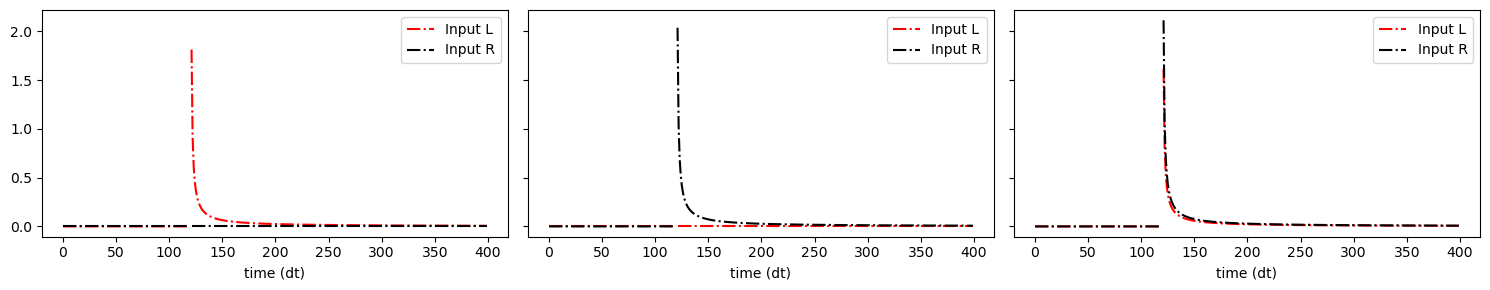

In [42]:
if GD:   
    fig, axes = subplots(1, ncols, sharey=True, sharex=True)
    fig.set_figheight(3); fig.set_figwidth(15)
    # title(f'Input shapes for u: "{stim_shape}" functions', fontsize=15)

    time_dts = jnp.r_[:ntime]
    for i_cond in cond_idx:

        # Extracting Matrices's coefficients from tensor of estimated values
        C_cond = C_gd_[i_cond]

        # Extracting Input's parameters from tensor of estimated values
        if stim_shape=='Gamma':
            alpha_cond, beta_cond = stim_pars_gd[i_cond,:ninputs], stim_pars_gd[i_cond,ninputs:]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, ntime=ntime, stim_onset=onset_ind, alpha=alpha_cond, beta=beta_cond)
        else:
            stim_tau_cond = stim_pars_gd[i_cond]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, ntime=ntime, stim_onset=onset_ind, stim_tau=stim_tau_cond)
            
        axes[i_cond].plot(C_cond[2,0]*stim[0, 0].T, 'r-.', label = 'Input L'); axes[i_cond].legend()
        axes[i_cond].plot(C_cond[5,1]*stim[0, 1].T, 'k-.', label = 'Input R'); axes[i_cond].legend()
        axes[i_cond].set_xlabel('time (dt)')
        
    tight_layout()

In [43]:
if GD and stim_shape=='Alpha':
    
    fig, axes = subplots(2, ncols, sharey=False, sharex=True)
    fig.set_figheight(8); fig.set_figwidth(15)

    time_dts = jnp.r_[:ntime]
    for i_cond in cond_idx:

        subplot(2,3,i_cond+1)
        hist(stim_pars_gd_all[i_cond,:,0],50,density=True, color='r'); title(f'{titles[i_cond]}:\n stim_tau_L', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
        
        subplot(2,3,i_cond+4)
        hist(stim_pars_gd_all[i_cond,:,1],50,density=True, color='k'); title('stim_tau_R', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
     
    tight_layout()    

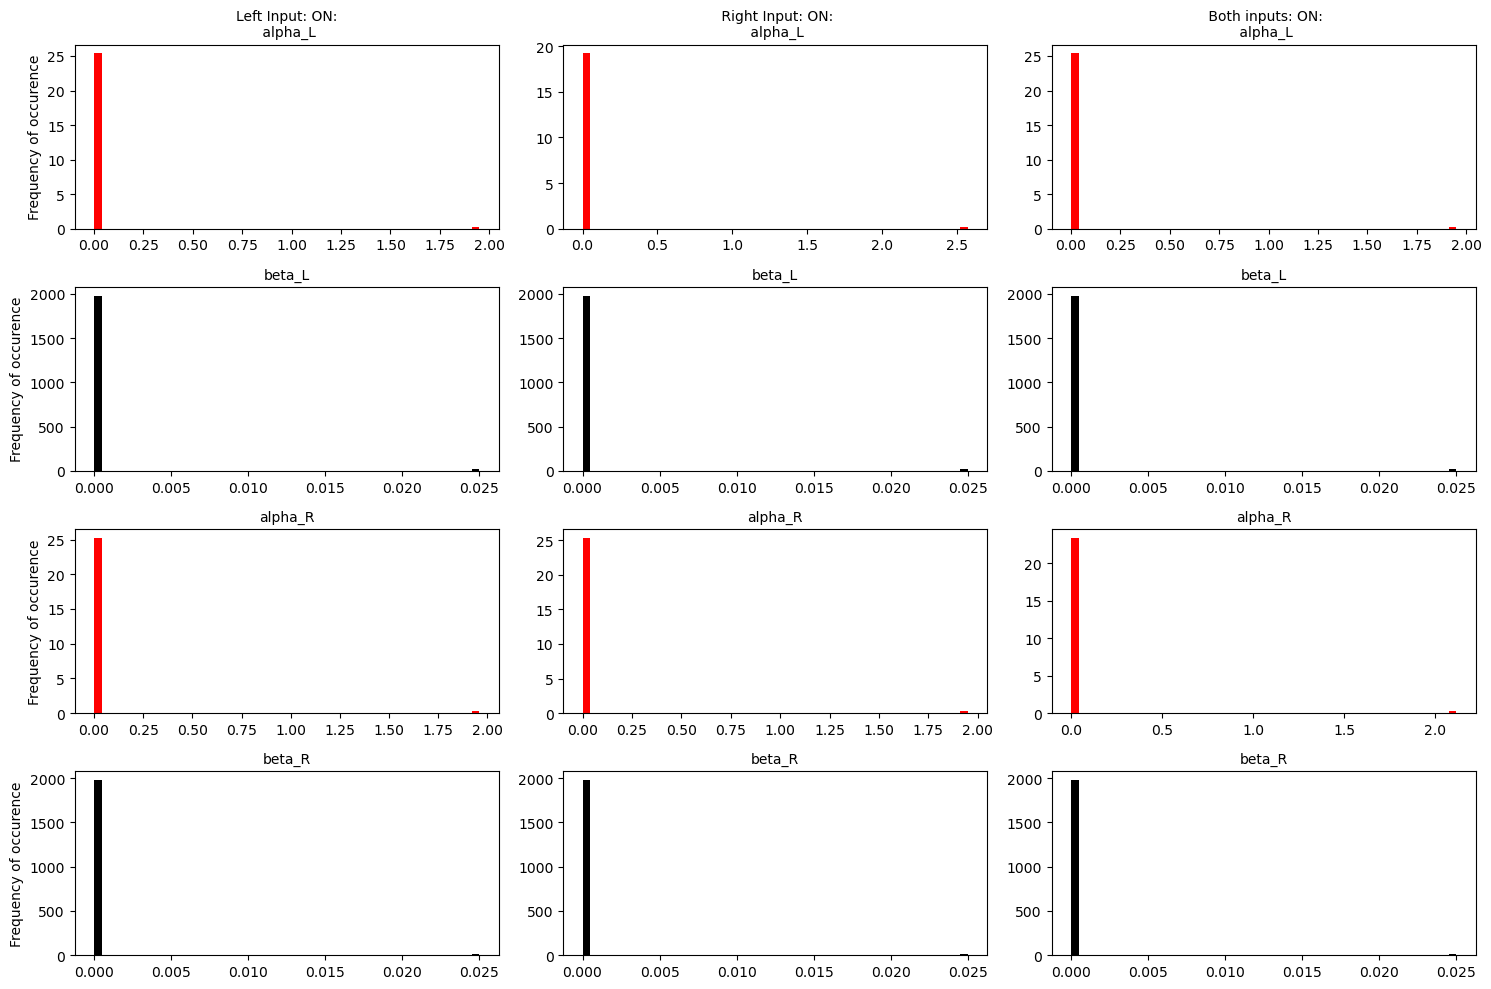

In [44]:
if GD and stim_shape=='Gamma':
    fig, axes = subplots(4, ncols)
    fig.set_figheight(10); fig.set_figwidth(15)

    time_dts = jnp.r_[:ntime]
    for i_cond in cond_idx:

        subplot(4,3,i_cond+1)
        hist(stim_pars_gd_all[i_cond,:,0],50,density=True, color='r'); title(f'{titles[i_cond]}:\n alpha_L', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
        
        subplot(4,3,i_cond+4)
        hist(stim_pars_gd_all[i_cond,:,2],50,density=True, color='k'); title('beta_L', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
        
        subplot(4,3,i_cond+7)
        hist(stim_pars_gd_all[i_cond,:,1],50,density=True, color='r'); title('alpha_R', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
        
        subplot(4,3,i_cond+10)
        hist(stim_pars_gd_all[i_cond,:,3],50,density=True, color='k'); title('beta_R', fontsize=10)
        if i_cond==0:
            ylabel('Frequency of occurence')
     
    tight_layout()

#### Further optimizing matrices A and C by means of jaxopt.LevenbergMarquardt

In [ ]:
if GD:
    from jaxopt import LevenbergMarquardt 

    A_gd = jnp.zeros((nconds,)+A.shape)
    C_gd = jnp.zeros((nconds,)+C.shape)
    stim_pars_cond = jnp.zeros((nconds,)+stim_pars_shape)
    
    Optimizer = LevenbergMarquardt(residual_fun=loss_fun_A_C, maxiter=70000, jit=False)
    for i_cond in cond_idx:
        
        tic = time.time()
        print(f'Fitting model configuration {i_cond+1}...')

        if sse_conds_[i_cond]<1e3:
            A_cond, C_cond = A_gd_[i_cond], C_gd_[i_cond]
            stim_pars_cond = stim_pars_cond.at[i_cond].set(stim_pars_gd[i_cond])
        else:
            exec(f'A = A_{A_str}')
            A_cond, C_cond = A, C
            stim_pars_cond = stim_pars_cond.at[i_cond].set(jnp.reshape(stim_pars_vec, stim_pars_shape))
            
        # Form a flat vector on non-null coefficients in C
        C_cond_nZero_idx = jnp.where(C_cond*conditions[i_cond])
        C_stim = C_cond[C_cond_nZero_idx]

        # Form a flat vector on non-null coefficients in A
        A_triu_idx, A_tril_idx = nZero_coeff_idx(A_cond)
        A_triu_vec, A_tril_vec = A_cond[A_triu_idx], A_cond[A_tril_idx]
        size_triu, size_tril = len(A_triu_idx[0]), len(A_tril_idx[0])
        A_diag_arr = jnp.asarray([A_cond[0,0]])
        
        p_hat_vec = jnp.concatenate([A_triu_vec, A_tril_vec, A_diag_arr, C_stim])

        # Call Levenberg-Marquardt algorithm
        # print(f'Intitial A_diag value: {A_cond[0,0]: .3f}')
        Optimizer_sol = Optimizer.run(p_hat_vec, A_triu_idx, A_tril_idx, B, C.shape, C_cond_nZero_idx, stim_pars_cond[i_cond], \
                                      stim_sh, tau, TRLs, dt, x0, ntime, onset_ind, eps, xs_exp)
        # Reconstruct matrix A from a flat vector of estimated coefficients
        A_triu_vec = jax.lax.dynamic_slice(Optimizer_sol.params, (0,), (size_triu,))
        A_gd_triu_idx = (jnp.tile(i_cond,(size_triu,)),) + A_triu_idx
        A_gd = A_gd.at[A_gd_triu_idx].set(A_triu_vec)  
    
        A_tril_vec = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu,), (size_tril,))
        A_gd_tril_idx = (jnp.tile(i_cond,(size_tril,)),) + A_tril_idx
        A_gd = A_gd.at[A_gd_tril_idx].set(A_tril_vec)

        A_gd_diag = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu+size_tril,), (1,))
        A_gd_diag_idx = (jnp.tile(i_cond,(nvar,)),) + diag_idx
        A_gd = A_gd.at[A_gd_diag_idx].set(A_gd_diag) # Damped dynamics at each node
        print(f'   Estimated A_diag value: {A_gd_diag[0]: .3f}')

        # Reconstruct matrix C from a flat vector of estimated coefficients
        C_opt = jax.lax.dynamic_slice(Optimizer_sol.params, (size_triu+size_tril+1,),(len(C_stim),))
        C_gd_nZero_idx = (jnp.tile(i_cond,(len(C_stim),)),) + C_cond_nZero_idx
        C_gd = C_gd.at[C_gd_nZero_idx].set(C_opt)

        toc = time.time() - tic
        print(f'   Elapsed time: {toc: .2f} secs')

Fitting model configuration 1...


In [ ]:
if GD:   
    fig, axes = subplots(nrows, ncols, sharey=True, sharex=True)
    fig.set_figheight(20); fig.set_figwidth(15)

    sse_conds = []
    time_dts = jnp.r_[:ntime]
    for i_cond in cond_idx: # range(nconds):
        # Extracting Matrices's coefficients from tensor of estimated values
        A_cond, C_cond = A_gd[i_cond], C_gd[i_cond]

        # Extracting Input's parameters from tensor of estimated values
        if stim_shape=='Gamma':
            alpha_cond, beta_cond = stim_pars_cond[i_cond,:ninputs], stim_pars_cond[i_cond,ninputs:]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, alpha=alpha_cond, beta=beta_cond)
        else:
            stim_tau_cond = stim_pars_cond[i_cond]
            stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, stim_tau=stim_tau_cond)
        us_hat = jnp.matrix_transpose(stim[...,ts])
                
        phat = vb.DCMTheta(A=A_cond/tau, B=B/tau, C=C_cond/tau)
        xs_hat_gd = dcm_bilinear_predict(x0, ts, us_hat, phat, eps).squeeze()
        
        sse_cond = sse(xs_hat_gd, xs_exp)
        sse_conds.append(sse_cond)
        for roi in ROIs:
            ax = axes[roi,i_cond]   
    
            # Plot prediction
            ax.plot(ts, xs_hat_gd[:,roi], color=color[roi], linestyle='-.')
            ax.plot(time_dts, xs_mean[:,roi], color=color[roi])
            if roi==0:
                ax.set_title(f'{titles[i_cond]}:\n sse = {sse_cond:0.2e}', fontsize=18)
            if roi==nvar-1:
                ax.set_xlabel('time (dt)')
            if i_cond==0:
                ax.text(.1,.7, name_ROIs_set.iat[roi], fontsize=15)
                
    tight_layout()

#### Matrix A: relation between experimental data and estimated effective connectivity

In [ ]:
# %%script false --no-raise-error
if GD:
    vmin, vmax = -1, 1
    title_size = 10
    
    fig = figure(figsize=(12,7))
    subplot(1,4,1); plot_matrix(A=gc_ref, shrink = 0.75, title_str=f'gc{thr_str}', title_size=12, ytickls=name_ROIs_set, xtickls=name_ROIs_set)
    
    for i_cond in cond_idx:
        A_gd_max = [jnp.abs(A_gd[i_cond]).max() for i_cond in cond_idx]
        
        subplot(2,4,i_cond + 2); plot_matrix(A=A_gd[i_cond]/A_gd_max[i_cond], \
                                             title_str=f'{titles[i_cond]} \n sse={sse_conds[i_cond]:.2e} \n\n Ahat_gd/|max|, |max|={A_gd_max[i_cond]:.2f}', \
                                             title_size=title_size, vmin=vmin, vmax=vmax, shrink = 0.75)
        subplot(2,4,i_cond + 6); plot_matrix(A=jnp.abs(A_gd[i_cond])/A_gd_max[i_cond], \
                                             title_str='|Ahat_gd|/|max|', \
                                             title_size=title_size, vmin=vmin, vmax=vmax, shrink = 0.75)
        
    tight_layout()

In [ ]:
if GD:
    figure(figsize=(17,8))

    for i_cond in cond_idx: # range(nconds):
        # Extracting Matrices's coefficients from tensor of estimated values
        A_cond = A_gd[i_cond]

        # Plotting A vs experimental GC
        subplot(2,3,i_cond+1)
        y = jnp.concatenate([    gc[A_triu_idx],     gc[A_tril_idx]])
        x = jnp.concatenate([A_cond[A_triu_idx], A_cond[A_tril_idx]])/A_gd_max[i_cond]
        plot(x,y,'o')
        title(f'{titles[i_cond]} \n sse={sse_conds[i_cond]:.2e}', fontsize=14)
        xlabel(f'Ahat_gd/|max|, |max|={A_gd_max[i_cond]:.2f}', fontsize=10)
        xlim(-1,1)
        if i_cond==0:
            ylabel('gc')

       # Plotting |A| vs experimental GC
        # Plotting |A| vs experimental GC
        subplot(2,3,i_cond+4)
        y = jnp.concatenate([   gc[A_triu_idx],    gc[A_tril_idx]])
        x = jnp.concatenate([jnp.abs(A_cond[A_triu_idx]), jnp.abs(A_cond[A_tril_idx])])/A_gd_max[i_cond]
        plot(x,y,'o')
        xlabel('|Ahat_gd|/|max|', fontsize=10)
        if i_cond==0:
            ylabel('gc')

    tight_layout()

In [ ]:
if GD:
    figure(figsize=(6,5))
    
    C_all = jnp.concatenate( [ jnp.asarray( [C_gd[i_cond] for i_cond in cond_idx]), \
                               jnp.expand_dims(C,axis=0) 
                             ]
                           )
    vmin, vmax = jnp.min(C_all), jnp.max(C_all)
    
    for i_cond in cond_idx:
        if i_cond==0:
            ytickls=name_ROIs_set
        else:
            ytickls=False

        if i_cond==2:
            cbar=True
        else:
            cbar=False
        subplot(2,3,i_cond+1); plot_matrix(A=C*conditions[i_cond], title_str=titles[i_cond], title_size=12, \
                                           shrink=0.85, vmin=vmin, vmax=vmax, ytickls=ytickls, no_diag=False)
        
        subplot(2,3,i_cond+4); plot_matrix(A=C_gd[i_cond], title_str='', shrink=0.85, \
                                           vmin=vmin, vmax=vmax, ytickls=ytickls, xtickls=['Input L', 'Input R'], no_diag=False)
    
    suptitle('C (top), C_gd (bottom)', fontsize=15)
    tight_layout()

### Bayesian optimization

#### (1) Model the likelihood of data

In [ ]:
# Example of Model likelihood for i_cond = 2
Lambda_max = 60
Lambda = Lambda_max
if GD:
    model = numpyro.sample('xs_hat_c', dist.MultivariateNormal(loc=xs_hat_gd, covariance_matrix=1/Lambda*cov_matrix), rng_key=keys[6])
    
    nrows, ncols = int(nvar/2),2
    fig, axes = subplots(nrows, ncols, sharey=True, sharex=True)
    fig.set_figheight(3*nrows); fig.set_figwidth(15)
    
    time_dts = jnp.r_[:ntime]
    for row in ROIs[:nrows]:
        # Plot prediction (left hemisphere)
        axes[row,0].plot(time_dts, xs_mean[:,row], color[row])
        axes[row,0].plot(ts, model[:,row], color[row])
        axes[row,0].text(.1,1.2, name_ROIs_set.iat[row] + ' vs Model Likelihood' , fontsize=15)
        
        # Plot prediction (right hemisphere)axes[row,0].plot(time_dts_, xs_mean[:,row][:,row], color[row])
        axes[row,1].plot(time_dts, xs_mean[:,row+3], color[row+3])
        axes[row,1].plot(ts, model[:,row+3], color[row+3])
        axes[row,1].text(.1,1.2, name_ROIs_set.iat[row+3] + ' vs Model Likelihood' , fontsize=15)
        if row==nrows-1:
            axes[row,0].set_xlabel('time (samples)')            
            axes[row,1].set_xlabel('time (samples)')
        
suptitle('Experimental data vs. Model Likelihood', fontsize=22)
tight_layout()

#### (2) Full Generative Model: Priors + Likelihood Model

In [ ]:
GD, GC_std = False, True

In [ ]:
def DCM_bilinear(Ahat0, Ahat0_triu_idx, Ahat0_tril_idx, A_fract, Chat0, Chat0_nZero_idx, stim_pars_cond, i_cond, xs_exp):

    #### Priors for matrix A ####
    A_hat = jnp.zeros(Ahat0.shape)
    if GD:
        Ahat0_diag = Ahat0[0,0]
    else:
        Ahat0_diag = A[0,0]
    ## Damped dynamics for matrix A_hat
    A_hat = A_hat.at[diag_idx].set(Ahat0_diag)
    # A_diag_std = A_fract*jnp.abs(Ahat0_diag)
    # A_diag_hat = numpyro.sample('A_diag_hat', dist.Normal(Ahat0_diag, A_diag_std))
    # A_hat = A_hat.at[diag_idx].set(A_diag_hat)
  
    ### Complete A_hat from a flat array on non-null coefficients in Ahat0
    ## Upper triangle for A_hat
    if Ahat0_triu_idx:
        Ahat0_triu_vec = Ahat0[Ahat0_triu_idx]
        Ahat0_triu_std = A_fract*jnp.abs(Ahat0_triu_vec)
        if GC_std:
            Ahat0_triu_hat = numpyro.sample('A_triu_hat', dist.Normal(0., Ahat0_triu_std))
        else:
            Ahat0_triu_hat = numpyro.sample('A_triu_hat', dist.Normal(Ahat0_triu_vec, Ahat0_triu_std))
        A_hat = A_hat.at[Ahat0_triu_idx].set(Ahat0_triu_hat)
    ## Lower triangle for A_hat
    if Ahat0_tril_idx:
        Ahat0_tril_vec = Ahat0[Ahat0_tril_idx]
        Ahat0_tril_std = A_fract*jnp.abs(Ahat0_tril_vec)
        if GC_std:
            Ahat0_tril_hat = numpyro.sample('A_tril_hat', dist.Normal(0., Ahat0_tril_std))
        else:
            Ahat0_tril_hat = numpyro.sample('A_tril_hat', dist.Normal(Ahat0_tril_vec, Ahat0_tril_std))
        A_hat = A_hat.at[Ahat0_tril_idx].set(Ahat0_tril_hat)
    ## A_hat
    A_hat = numpyro.deterministic(f'A_hat_{i_cond}', A_hat)
    
    #### Priors for matrix C ####
    C_hat = jnp.zeros(Chat0.shape)
    ### Complete C_hat from a flat array on non-null coefficients in Chat0
    Chat0_vec = jnp.expand_dims(Chat0[Chat0_nZero_idx], axis=1)
    Chat0_hat = numpyro.sample('C_hat', dist.LogNormal(jnp.log(Chat0_vec),1/16))
    C_hat = C_hat.at[Chat0_nZero_idx].set(Chat0_hat.squeeze())
    C_hat = numpyro.deterministic(f'C_hat_{i_cond}',C_hat)
    
    #### Priors for the stimuli ####
    if stim_shape=='Gamma':
        # Parameters for Gamma-shape input functions, approx. as in Chen et al.[2008]
        alpha_cond, beta_cond = stim_pars_cond[:ninputs], stim_pars_cond[ninputs:]
        theta_sigma = numpyro.sample(f'theta_sigma_{i_cond}', dist.LogNormal(jnp.log(alpha_cond/beta_cond**2),1/16))
        while True: # alpha must be larger than 1
            theta_mu = numpyro.sample(f'theta_mu_{i_cond}', dist.LogNormal(jnp.log(alpha_cond/beta_cond),1/16))
            if (theta_mu > jnp.sqrt(theta_sigma)).all:
                break
                
        alpha = numpyro.deterministic(f'alpha_{i_cond}', theta_mu**2/theta_sigma)
        beta = numpyro.deterministic(f'beta_{i_cond}', theta_mu/theta_sigma)
        stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, alpha=alpha, beta=beta)
    else:
        stim_tau_cond = stim_pars_cond
        stim_tau_hat = numpyro.sample(f'stim_tau_{i_cond}', dist.LogNormal(jnp.log(stim_pars_cond),1/16))
        stim = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, stim_tau=stim_tau_hat)
        
    stim_hat = numpyro.deterministic(f'stim_{i_cond}', stim[...,ts])
    us_hat = jnp.matrix_transpose(stim_hat)
    
    ### Prior for tau ####
    tau_hat = numpyro.sample(f'tau_{i_cond}', dist.LogNormal(jnp.log(tau),1/16)) # in seconds
    
    ### Bilinear model's output ####
    p_hat = vb.DCMTheta(A=A_hat/tau_hat, B=B/tau_hat, C=C_hat/tau_hat)
    xs_hat_c = dcm_bilinear_predict(x0, ts, us_hat, p_hat, eps)

    #### Likelihood model ####
    Lambda = numpyro.sample(f'Lambda_{i_cond}', dist.LogNormal(jnp.log(Lambda_max),1))
    numpyro.sample(f'xs_hat_c_{i_cond}', dist.MultivariateNormal(loc=xs_hat_c, covariance_matrix=1/Lambda*cov_matrix), obs=xs_exp)

In [ ]:
i_cond = 0
if GD:
    Ahat0, A_fract = A_gd.at[i_cond].get(), 0.03
    Chat0 = C_gd.at[i_cond].get()
else:
    Ahat0, Chat0 = gc_ref, C*conditions[i_cond]
    if GC_std: # Approx. as in Chen et al. (2008)
        A_fract = 1.
    else:
        A_fract = 0.75
Ahat0_triu_idx, Ahat0_tril_idx = nZero_coeff_idx(Ahat0)
Chat0_nZero_idx = jnp.where(Chat0)

data = (Ahat0, Ahat0_triu_idx, Ahat0_tril_idx, A_fract, Chat0, Chat0_nZero_idx, \
        stim_pars_cond[i_cond], i_cond, xs_exp,)
filegraph = f'../../../figs/DCM/model_building/DCM_Bilinear_dataset_inferA_ProbGraph.png'
numpyro.render_model(DCM_bilinear, model_args=data, render_params=True, render_distributions=True) #, filename=filegraph)

##### Bayesian Optimization method: Markov Chains Monte Carlo

In [ ]:
from numpyro.infer import MCMC, NUTS, init_to_mean, init_to_median
from joblib import Parallel, delayed

num_chains = int(jax.local_device_count()/len(conditions))
rng_key = jax.random.PRNGKey(1106)

def fit_model_conf(i_cond):
    print(f'Fitting model configuration {i_cond+1}...')
            
    if GD:
        Ahat0, A_fract = A_gd.at[i_cond].get(), 0.03
        Chat0 = C_gd.at[i_cond].get()
    else:
        Ahat0, Chat0 = gc_ref, C*conditions[i_cond]
        if GC_std: # To use GC in std of the prior probability for matrix A, resembling the approach in Chen et al. (2008)
            A_fract = 1.
        else:      # To use GC as mean of the prior probability for matrix A
            A_fract = 0.10
    Ahat0_triu_idx, Ahat0_tril_idx = nZero_coeff_idx(Ahat0)
    Chat0_nZero_idx = jnp.where(Chat0)

    nuts_kernel = NUTS(DCM_bilinear, target_accept_prob=0.95, init_strategy=init_to_mean)
    mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=1000, num_chains=num_chains)
    mcmc.run(rng_key, Ahat0, Ahat0_triu_idx, Ahat0_tril_idx, A_fract, \
             Chat0, Chat0_nZero_idx, stim_pars_cond[i_cond], i_cond, xs_exp)
    
    postSamples = mcmc.get_samples()
    DCM_PredictiveObject = Predictive(model=DCM_bilinear, posterior_samples=postSamples)
    postPredData = DCM_PredictiveObject(rng_key, Ahat0, Ahat0_triu_idx, Ahat0_tril_idx, A_fract, \
                                        Chat0, Chat0_nZero_idx, stim_pars_cond[i_cond], i_cond, xs_exp=None)

    return postSamples, postPredData

In [ ]:
cond_idx = [0,1,2]
element_run = Parallel(n_jobs=-1)(delayed(fit_model_conf)(i_cond) for i_cond in cond_idx)

for i_run,i_cond in enumerate(cond_idx):
    exec(f'postSamples_{i_cond}, postPredData_{i_cond} = element_run[{i_run}]')

#### Model outputs VS experimental data

In [ ]:
nrows, ncols = nvar, len(conditions)
fig, axes = subplots(nrows, ncols, sharey=True, sharex=True)
fig.set_figheight(2*nrows); fig.set_figwidth(15)

sse_conds_bayes = []
color=['b', 'g', 'r', 'c', 'y', 'k']
for i_cond in cond_idx:

    # Inputs
    '''
    # Mean-parameter estimated inputs
    if stim_shape=='Alpha':
        exec(f'stim_tau_hat = postSamples_{i_cond}["stim_tau_{i_cond}"].mean()')
        stim_phat_mean = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, stim_tau=stim_tau_hat)
    else:
        exec(f'alpha_hat = postSamples_{i_cond}["alpha_{i_cond}"].mean()')
        exec(f'beta_hat = postSamples_{i_cond}["beta_{i_cond}"].mean()')
        stim_phat_mean = stim_signal(shape=stim_shape, ninputs=ninputs, stim_onset=onset_ind, alpha=alpha_hat, beta=beta_hat)
    us_hat_mean = jnp.matrix_transpose(stim_phat_mean)
    
    # Model prediction with the mean phat, tau_hat and us_hat
    exec(f'A_hat = postSamples_{i_cond}["A_hat_{i_cond}"].mean(axis=0)')
    exec(f'C_hat = postSamples_{i_cond}["C_hat_{i_cond}"].mean(axis=0)')
    exec(f'tau_hat = postSamples_{i_cond}["tau_{i_cond}"].mean()')
    phat = vb.DCMTheta(A=A_hat/tau_hat, B=B/tau_hat, C=C_hat/tau_hat)
    xs_phat_mean = dcm_bilinear_predict(x0, ts, us_hat_mean, phat, eps).squeeze()
    '''
    
    # Mean estimated model prediction
    xs_name = f'xs_hat_c_{i_cond}'
    exec(f'xs_hat_mean = jnp.mean(postPredData_{i_cond}["{xs_name}"], axis=0).squeeze()')
    # 90% confidence intervals
    # exec(f'percentiles = jnp.percentile(postSamples_{i_cond}["{xs_name}"], jnp.asarray([5.0, 95.0]), axis=0).squeeze()')
    exec(f'percentiles = jnp.percentile(postPredData_{i_cond}["{xs_name}"], jnp.asarray([5.0, 95.0]), axis=0).squeeze()')

    sse_cond = sse(xs_hat_mean, xs_exp)
    sse_conds_bayes.append(sse_cond)
    
    for roi in ROIs:
        ax = axes[roi,i_cond]

        # Plot model predictions VS experimental data
        ax.plot(time_dts, xs_mean[:,roi], color=color[roi])
        # ax.plot(time_dts, xs_phat_mean[:,roi], color=color[roi], linestyle=':')
        ax.plot(ts, xs_hat_mean[:,roi], color=color[roi], linestyle='-.')
        
        # plot 90% confidence level of predictions
        ax.fill_between(ts, percentiles[0,...,roi], percentiles[1,...,roi], color="lightblue")
        if roi==0:
            ax.set_title(f'{titles[i_cond]}:\n sse = {sse_cond:0.2e}', fontsize=18)
        if roi==nvar-1:
            ax.set_xlabel('time (dt)')
        if i_cond==0:
            ax.text(.1,0.7, name_ROIs_set.iat[roi], fontsize=15)
            
tight_layout()

### Inferred average values of parameters

In [ ]:
# postSamples_0.keys(), postPredData_0.keys()

#### Matrix A: relation between experimental data and estimated effective connectivity

In [ ]:
# %%script false --no-raise-error
vmin, vmax = -1, 1

fig = figure(figsize=(12,7.5))
subplot(1,4,1); plot_matrix(A=gc_ref, shrink = 0.75, title_str=f'gc{thr_str}', title_size=12)

for i_cond in cond_idx:
    exec(f'A_hat = postSamples_{i_cond}["A_hat_{i_cond}"].mean(axis=0)')
    A_hat_max = jnp.abs(A_hat).max()
    subplot(2,4,i_cond + 2); plot_matrix(A=A_hat/A_hat_max, \
                                         title_str=f'{titles[i_cond]} \n sse={sse_conds_bayes[i_cond]:.2e} \n\n Ahat_Bay/|max|, |max|={A_hat_max:.2f}', \
                                         title_size=12, shrink = 0.75, vmin=vmin, vmax=vmax)
    
    subplot(2,4,i_cond + 6); plot_matrix(A=jnp.abs(A_hat)/A_hat_max, title_str='|Ahat_Bay|/|max|', title_size=12, shrink = 0.75)

tight_layout()

In [ ]:
figure(figsize=(17,8))

for i_cond in cond_idx: # range(nconds):
        
    exec(f'A_hat = postSamples_{i_cond}["A_hat_{i_cond}"].mean(axis=0)')
    A_hat_max = jnp.abs(A_hat).max()
    
    # Plotting A vs experimental GC
    subplot(2,3,i_cond+1)
    y = jnp.concatenate([   gc[A_triu_idx],    gc[A_tril_idx]])
    x = jnp.concatenate([A_hat[A_triu_idx], A_hat[A_tril_idx]])/A_hat_max
    plot(x,y,'o')
    title(f'{titles[i_cond]} \n sse={sse_conds_bayes[i_cond]:.2e}', fontsize=14)
    xlabel(f'Ahat_Bay/|max|, |max|={A_hat_max:.2f}', fontsize=10)
    xlim(-1,1)
    if i_cond==0:
        ylabel('gc')

    # Plotting |A| vs experimental GC
    subplot(2,3,i_cond+4)
    y = jnp.concatenate([   gc[A_triu_idx],    gc[A_tril_idx]])
    x = jnp.concatenate([jnp.abs(A_hat[A_triu_idx]), jnp.abs(A_hat[A_tril_idx])])/A_hat_max
    plot(x,y,'o')
    xlabel(f'|Ahat_Bay|/|max|', fontsize=10)
    if i_cond==0:
        ylabel('gc')

tight_layout()

#### Matrix C

In [ ]:
figure(figsize=(5,5))

for i_cond in cond_idx:
    if GD:
        Chat0 = C_gd.at[i_cond].get()
    else:
        Chat0 = C*conditions[i_cond]
    
    exec(f'C_hat = postSamples_{i_cond}["C_hat_{i_cond}"].mean(axis=0)')
    subplot(2,3,i_cond+1); plot_matrix(A=Chat0, title_str=titles[i_cond], title_size=12, shrink=0.85, no_diag=False)
    subplot(2,3,i_cond+4); plot_matrix(A=C_hat, title_str=titles[i_cond], title_size=12, shrink=0.85, no_diag=False)

suptitle('C_prior (top), C_hat (bottom)', fontsize=15)

tight_layout()

#### Effective stimuli: C_hat*stim_hat

In [ ]:
# Plotting estimated vs original inputs
inputs = range(0,ninputs)
nrows, ncols = ninputs, len(conditions)
fig, axes = subplots(nrows, ncols, sharey=True, sharex=True)
fig.set_figheight(3*nrows); fig.set_figwidth(20)

for i_cond in cond_idx:
    
    if GD:
        Chat0 = C_gd.at[i_cond].get()
    else:
        Chat0 = C*conditions[i_cond]
        
    exec(f'C_hat = postSamples_{i_cond}["C_hat_{i_cond}"].mean(axis=0)')

    # Mean estimated inputs
    exec(f'stim_hat_mean = jnp.mean(postPredData_{i_cond}["stim_{i_cond}"], axis=0).squeeze().T')
    # 90% confidence intervals
    exec(f'stim_percentiles = jnp.percentile(postPredData_{i_cond}["stim_{i_cond}"], jnp.asarray([5.0, 95.0]), axis=0).squeeze()')
        
    for i_inp in inputs:
        ax = axes[i_inp,i_cond]
        # Plot mean prediction
        if i_inp==0:
            node_stim, color = 2, 'r'
        else:
            node_stim, color = 5, 'k'
            
        # ax.plot(time_dts, jnp.c_[C_hat[node_stim,i_inp]*stim_hat_mean[:,i_inp].T, C_hat[node_stim,i_inp]*stim_phat_mean[:,i_inp].T])
        ax.plot(ts, jnp.c_[C_hat[node_stim,i_inp]*stim_hat_mean[:,i_inp].T, Chat0[node_stim,i_inp]*stim[:,i_inp,onset_ind:].T], color=color, linestyle='-.')
        # plot 90% confidence level of predictions
        ax.fill_between(ts, C_hat[node_stim,i_inp]*stim_percentiles[0,i_inp], C_hat[node_stim,i_inp]*stim_percentiles[1,i_inp], color="lightblue")
        if i_inp==0:
            ax.set_title(titles[i_cond], fontsize=18)
        '''
        if i_cond==0:
            if i_inp==0:
                ax.text(.1,.7,'Left', fontsize=15)
            else:
                ax.text(.1,.7, 'Right', fontsize=15)
        '''
        if i_inp==ninputs-1:
            ax.set_xlabel('time (dt)',fontsize=13)

### Comparing priors and posterior probabilities for parameters

In [ ]:
i_cond=2

#### Convergence time constant: tau

In [ ]:
# Posterior samples
exec(f'tau_hat_all = postSamples_{i_cond}["tau_{i_cond}"]')

In [ ]:
# Prior samples
tau_pr = numpyro.sample(f'tau_{i_cond}', dist.LogNormal(jnp.log(tau),1/16), sample_shape=(tau_hat_all.shape[0],), rng_key=rng_key) # in seconds
tau_pr.shape

In [ ]:
# Plotting Prior vs Posterior distributions
figure(figsize=(15,3))
ft_s = 10

subplot(131); hist(tau_pr,50, density=True, color='c'); title('tau_prior', fontsize=ft_s)
subplot(132); hist(tau_hat_all,50, density=True, color='b'); title('tau_post', fontsize=ft_s)
subplot(133); hist([tau_pr, tau_hat_all],100, density=True, color=['c','b']); title('tau_prior VS tau_post', fontsize=ft_s)

#### Covariance scale of the observation noise: Lambda

In [ ]:
# Posterior samples
exec(f'Lambda_hat_all = postSamples_{i_cond}["Lambda_{i_cond}"]')

In [ ]:
# Prior samples
Lambda_pr = numpyro.sample(f'Lambda_{i_cond}', dist.LogNormal(jnp.log(Lambda_max),1), sample_shape=(Lambda_hat_all.shape[0],), rng_key=rng_key)

In [ ]:
# Plotting Prior vs Posterior distributions
figure(figsize=(15,3))
subplot(131); hist(Lambda_pr,50, density=True, color='c'); title('Lambda_prior', fontsize=ft_s)
subplot(132); hist(Lambda_hat_all,50, density=True, color='b'); title('Lambda_post', fontsize=ft_s)
subplot(133); hist([Lambda_pr, Lambda_hat_all],50, density=True, color=['c','b']); title('Lambda_prior VS Lambda_post', fontsize=ft_s)

#### Stimuli parameters: stim_tau (for Alpha-shaped inputs) or alpha & beta (for Gamma-shaped inputs)

In [ ]:
import numpyro.infer, numpyro.distributions as dist

In [ ]:
# Posterior samples
if stim_shape=='Alpha':
    exec(f'stim_tau_hat_all = postSamples_{i_cond}["stim_tau_{i_cond}"].squeeze()')
else:
    exec(f'alpha_hat_all = postSamples_{i_cond}["alpha_{i_cond}"].squeeze().T')
    exec(f'beta_hat_all = postSamples_{i_cond}["beta_{i_cond}"].squeeze().T')
    exec(f'theta_mu_all  = postSamples_{i_cond}["theta_mu_{i_cond}"].squeeze()')
    exec(f'theta_sigma_all  = postSamples_{i_cond}["theta_sigma_{i_cond}"].squeeze()')

In [ ]:
# Prior samples
if stim_shape=='Alpha':
    stim_tau_cond = stim_pars_cond[i_cond]
    stim_tau_pr = numpyro.sample(f'stim_tau_{i_cond}', dist.LogNormal(jnp.log(stim_tau_cond),1/16), \
                                               sample_shape=(stim_tau_hat_all.shape[0],), rng_key=rng_key).squeeze().T
else:
    # Parameters for Gamma-shape input functions, as in Chen et al.[2008]
    alpha_cond, beta_cond = stim_pars_cond[i_cond,:ninputs], stim_pars_cond[i_cond,ninputs:]
    theta_mu_prior = numpyro.sample(f'theta_mu_{i_cond}', dist.LogNormal(jnp.log(alpha_cond/beta_cond),1/16), \
                                                         sample_shape=(theta_mu_all.shape[0],), rng_key=rng_key).squeeze().T
    theta_sigma_prior = numpyro.sample(f'theta_sigma_{i_cond}', dist.LogNormal(jnp.log(alpha_cond/beta_cond**2),1/16), \
                                                               sample_shape=(theta_sigma_all.shape[0],), rng_key=rng_key).squeeze().T

    alpha_prior = numpyro.deterministic(f'alpha_{i_cond}', theta_mu_prior**2/theta_sigma_prior)
    beta_prior = numpyro.deterministic(f'beta_{i_cond}', theta_mu_prior/theta_sigma_prior)

In [ ]:
# Plotting Prior vs Posterior distributions
if stim_shape=='Alpha':
    figure(figsize=(15,8))
    subplot(231); hist(stim_tau_pr[0],50,density=True, color='c'); title('stim_tau_L_prior', fontsize=ft_s); ylabel('Probability')
    subplot(232); hist(stim_tau_hat_all[...,0],50,density=True, color='b'); title('stim_tau_L_post', fontsize=ft_s)
    subplot(233); hist([stim_tau_pr[0], stim_tau_hat_all[...,0]],100, density=True, color=['c','b'])
    title('stim_tau_L_prior VS stim_tau_L_post', fontsize=ft_s)

    subplot(234); hist(stim_tau_pr[1],50,density=True, color='c'); title('stim_tau_R_prior', fontsize=ft_s); ylabel('Probability')
    subplot(235); hist(stim_tau_hat_all[...,1],50,density=True, color='b'); title('stim_tau_R_post', fontsize=ft_s)
    subplot(236); hist([stim_tau_pr[1], stim_tau_hat_all[...,1]],100, density=True, color=['c','b'])
    title('stim_tau_R_prior VS stim_tau_R_post', fontsize=ft_s)

In [ ]:
if stim_shape=='Gamma':
    figure(figsize=(15,10))
    subplot(431); hist(theta_mu_prior[0],50,density=True, color='c'); title('theta_mu_L_prior', fontsize=ft_s); ylabel('Probability')
    subplot(432); hist(theta_mu_all[...,0],50,density=True, color='b'); title('theta_mu_L_post', fontsize=ft_s)
    subplot(433); hist([theta_mu_prior[0], theta_mu_all[...,0]],100, density=True, color=['c','b'])
    title('theta_mu_L_prior VS theta_mu_L_post', fontsize=ft_s)

    subplot(434); hist(theta_sigma_prior[0],50,density=True, color='c'); title('theta_sigma_L_prior', fontsize=ft_s); ylabel('Probability')
    subplot(435); hist(theta_sigma_all[...,0],50,density=True, color='b'); title('theta_sigma_L_post', fontsize=ft_s)
    subplot(436); hist([theta_sigma_prior[0], theta_sigma_all[...,0]],100, density=True, color=['c','b'])
    title('theta_sigma_L_prior VS theta_sigma_L_post', fontsize=ft_s)

    subplot(437); hist(alpha_prior[0],50,density=True, color='c'); title('alpha_L_prior', fontsize=ft_s); ylabel('Probability')
    subplot(438); hist(alpha_hat_all.T[...,0],50,density=True, color='b'); title('alpha_L_post', fontsize=ft_s)
    subplot(439); hist([alpha_prior[0], alpha_hat_all.T[...,0]],100, density=True, color=['c','b'])
    title('alpha_L_prior VS alpha_L_post', fontsize=ft_s)

    subplot(4,3,10); hist(beta_prior[0],50,density=True, color='c'); title('beta_L_prior', fontsize=ft_s); ylabel('Probability')
    subplot(4,3,11); hist(beta_hat_all.T[...,0],50,density=True, color='b'); title('beta_L_post', fontsize=ft_s)
    subplot(4,3,12); hist([beta_prior[0], beta_hat_all.T[...,0]],100, density=True, color=['c','b'])
    title('beta_L_prior VS beta_L_post', fontsize=ft_s)
tight_layout()

In [ ]:
if stim_shape=='Gamma':
    figure(figsize=(15,10))
    subplot(431); hist(theta_mu_prior[1],50,density=True, color='c'); title('theta_mu_R_prior', fontsize=ft_s); ylabel('Probability')
    subplot(432); hist(theta_mu_all[...,1],50,density=True, color='b'); title('theta_mu_R_post', fontsize=ft_s)
    subplot(433); hist([theta_mu_prior[1], theta_mu_all[...,1]],100, density=True, color=['c','b']);
    title('theta_mu_R_prior VS theta_mu_R_post', fontsize=ft_s)

    subplot(434); hist(theta_sigma_prior[1],50,density=True, color='c'); title('theta_sigma_R_prior', fontsize=ft_s); ylabel('Probability')
    subplot(435); hist(theta_sigma_all[...,1],50,density=True, color='b'); title('theta_sigma_R_post', fontsize=ft_s)
    subplot(436); hist([theta_sigma_prior[1], theta_sigma_all[...,1]],100, density=True, color=['c','b'])
    title('theta_sigma_R_prior VS theta_sigma_R_post', fontsize=ft_s)

    subplot(437); hist(alpha_prior[1],50,density=True, color='c'); title('alpha_R_prior', fontsize=ft_s); ylabel('Probability')
    subplot(438); hist(alpha_hat_all.T[...,1],50,density=True, color='b'); title('alpha_R_post', fontsize=ft_s)
    subplot(439); hist([alpha_prior[1], alpha_hat_all.T[...,1]],100, density=True, color=['c','b'])
    title('alpha_R_prior VS alpha_R_post', fontsize=ft_s)

    subplot(4,3,10); hist(beta_prior[1],50,density=True, color='c'); title('beta_R_prior', fontsize=ft_s); ylabel('Probability')
    subplot(4,3,11); hist(beta_hat_all.T[...,1],50,density=True, color='b'); title('beta_R_post', fontsize=ft_s)
    subplot(4,3,12); hist([beta_prior[1], beta_hat_all.T[...,1]],100, density=True, color=['c','b'])
    title('beta_R_prior VS beta_R_post', fontsize=ft_s)

tight_layout()

#### C_1 and C_2

In [ ]:
# Posterior samples
exec(f'C_hat_all = postSamples_{i_cond}["C_hat_{i_cond}"]')

In [ ]:
# Prior samples
if GD:
    Chat0 = C_gd.at[i_cond].get()
else:
    Chat0 = C*conditions[i_cond]

C_1_pr = numpyro.sample(f'C_L_hat', dist.LogNormal(jnp.log(Chat0[2,0]),1/16), sample_shape=(C_hat_all.shape[0],), rng_key=rng_key)
C_2_pr = numpyro.sample(f'C_R_hat', dist.LogNormal(jnp.log(Chat0[5,1]),1/16), sample_shape=(C_hat_all.shape[0],), rng_key=rng_key)

In [ ]:
# Plotting Prior vs Posterior distributions
figure(figsize=(15,6))

subplot(231); hist(C_1_pr,50,density=True, color='c'); title('C_L_prior', fontsize=ft_s); # ylabel('Probability')
subplot(232); hist(C_hat_all[...,2,0],50,density=True, color='b'); title('C_L_post', fontsize=ft_s)
subplot(233); hist([C_1_pr, C_hat_all[...,2,0]],100, density=True, color=['c','b']); title('C_L_prior VS C_L_post', fontsize=ft_s)

subplot(234); hist(C_2_pr,50,density=True, color='c'); title('C_R_prior', fontsize=ft_s); # ylabel('Probability')
subplot(235); hist(C_hat_all[...,5,1],50,density=True, color='b'); title('C_R_post', fontsize=ft_s)
subplot(236); hist([C_2_pr, C_hat_all[...,5,1]],100, density=True, color=['c','b']); title('C_R_prior VS C_R_post', fontsize=ft_s)

tight_layout()

#### Matrix A

In [ ]:
# Posterior samples of non-null coefficients in A_hat
exec(f'A_hat_all = postSamples_{i_cond}["A_hat_{i_cond}"]')
A_nZero_idx = jnp.concatenate([A_triu_idx[0], A_tril_idx[0]]), jnp.concatenate([A_triu_idx[1], A_tril_idx[1]])
A_hat_nZero = A_hat_all[:, A_nZero_idx[0], A_nZero_idx[1]] # Non-null coefficients in A_hat_all

n_nZero = len(A_nZero_idx[0]) # Number of non-null coeffcients in matrices A_hat_all
Ahat_lbs = [ f'A_hat[{A_nZero_idx[0][idx]},{A_nZero_idx[1][idx]}]' for idx in range(0,n_nZero) ]
data_all = pd.DataFrame(A_hat_nZero, columns = Ahat_lbs)
data_all

In [ ]:
# Prior samples
if GD:
    Ahat0, A_fract = A_gd.at[i_cond].get(), 0.03
else:
    Ahat0 = gc_ref
    if GC_std: # To use GC in std of the prior probability for matrix A, resembling the approach in Chen et al. (2008)
        A_fract = 1.
    else:      # To use GC as mean of the prior probability for matrix A
        A_fract = 0.6
Ahat0_std = A_fract*jnp.abs(Ahat0)

## Upper triangle for A_prior
if A_triu_idx:
    A_prior_triu_vec = Ahat0[A_triu_idx]
    A_prior_triu_std = A_fract*jnp.abs(A_prior_triu_vec)
    if GC_std:
        A_prior_triu = numpyro.sample('A_prior_triu', dist.Normal(0., A_prior_triu_std), sample_shape=(A_hat_all.shape[0],), rng_key=rng_key)
    else:
        A_prior_triu = numpyro.sample('A_prior_triu', dist.Normal(A_prior_triu_vec, A_prior_triu_std), sample_shape=(A_hat_all.shape[0],), rng_key=rng_key)
## Lower triangle for A_prior
if A_tril_idx:
    A_prior_tril_vec = Ahat0[A_tril_idx]
    A_prior_tril_std = A_fract*jnp.abs(A_prior_tril_vec)
    if GC_std:
        A_prior_tril = numpyro.sample('A_prior_tril', dist.Normal(0., A_prior_tril_std), sample_shape=(A_hat_all.shape[0],), rng_key=rng_key)
    else:
        A_prior_tril = numpyro.sample('A_prior_tril', dist.Normal(A_prior_tril_vec, A_prior_tril_std), sample_shape=(A_hat_all.shape[0],), rng_key=rng_key)

A_prior_nZero = jnp.concatenate([A_prior_triu, A_prior_tril], axis=1)

In [ ]:
# Plotting Prior vs Posterior distributions
numparams = n_nZero # Shouldn't be larger than n_nZero
idx_rnd = sort(random.sample(range(0,n_nZero), numparams))

figure(figsize=(15,3*nrows))

nrows, ncols = len(idx_rnd),3
n_subplts=nrows*ncols

for i_idx, idx in enumerate(idx_rnd):
        
    ax = subplot(nrows,ncols,1 + 3*i_idx)

    str_idx = f'{A_nZero_idx[0][idx]},{A_nZero_idx[1][idx]}'
    hist(A_prior_nZero[:,idx],50, density=True, color='c')
    title(f'A_prior[{str_idx}]', fontsize=ft_s)

    subplot(nrows,ncols,2 + 3*i_idx, sharex=ax) 
    hist(A_hat_nZero[:,idx],50, density=True, color='b')
    title(f'A_post[{str_idx}]', fontsize=ft_s)

    subplot(nrows,ncols,3 + 3*i_idx, sharex=ax)
    hist([A_prior_nZero[:,idx], A_hat_nZero[:,idx]],100, density=True, color=['c', 'b'])
    title(f'A_prior[{str_idx}] vs A_post[{str_idx}]', fontsize=ft_s)

tight_layout()

In [ ]:
g = sns.pairplot(data_all.iloc[:,idx_rnd], height=3, aspect=1, kind="hist", corner=True)
g.map_lower(sns.kdeplot, levels=4, color=".2")
# g.map_upper(sns.kdeplot, levels=4, color=".2")

In [ ]:
## Gelman-Rubin diagnostics for A_hat
rhat_A = numpyro.diagnostics.split_gelman_rubin(A_hat_nZero)
z_A = jnp.abs((A_prior_nZero.mean(axis=0) - A_hat_nZero.mean(axis=0)) / A_hat_nZero.std(axis=0))
s_A = 1 - A_hat_nZero.std(axis=0)/A_prior_nZero.std(axis=0)

plot(s_A.reshape(-1), z_A.reshape(-1), 'kx');
xlim([0, 1]); ylim([0, max(1,z_A.max())])
xlabel('Posterior shrinkage');
ylabel('Posterior z score');
grid(1)
f'max rhat {rhat_A.max():0.3f}'
title('Gelman-Rubin diagnostics for A', fontsize=15)